<a href="https://colab.research.google.com/github/Jay99Sohn/GEOexosome/blob/main/GEOexosome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0: Environment & Library Setup

# Optional: install required packages when running on Colab
# Uncomment the line below if running on Google Colab for the first time:
!pip install GEOparse imbalanced-learn shap seaborn matplotlib

# ============================================================
# Standard Library & Third-party Imports
# ============================================================

import os
import sys
import random
import json

import numpy as np
import pandas as pd
import GEOparse

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ============================================================
# Configuration & Reproducibility
# ============================================================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Set visualization style for reproducible plots
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300

print("\n" + "=" * 60)
print("ENVIRONMENT & LIBRARY SETUP")
print("=" * 60)

# ============================================================
# Environment Detection & Path Configuration
# ============================================================

if "google.colab" in sys.modules:
    from google.colab import drive
    print("[INFO] Google Colab detected. Mounting Google Drive...")
    drive.mount("/content/drive")
    base_save_path = "/content/drive/MyDrive/geoexosome_results"
    print(f"[INFO] Drive mounted. Saving results to: {base_save_path}")
else:
    base_save_path = "./geoexosome_results"
    print(f"[INFO] Local environment detected. Saving results to: {base_save_path}")

os.makedirs(base_save_path, exist_ok=True)

print("\n" + "=" * 60)
print("✓ Setup Complete")
print(f"  - Random seed: {SEED}")
print(f"  - Output path: {base_save_path}")
print("=" * 60 + "\n")



ENVIRONMENT & LIBRARY SETUP
[INFO] Google Colab detected. Mounting Google Drive...
Mounted at /content/drive
[INFO] Drive mounted. Saving results to: /content/drive/MyDrive/geoexosome_results

✓ Setup Complete
  - Random seed: 42
  - Output path: /content/drive/MyDrive/geoexosome_results



In [2]:
# ==============================================================================
# Cell 1: GEO Dataset Loading and Quality Control
# ==============================================================================
"""
Purpose:
    Download and parse the GSE39833 dataset from NCBI GEO, extract expression
    matrices, assign sample labels with full traceability, and perform
    comprehensive quality control checks.

Dataset:
    GSE39833 - Serum exosome miRNA microarray from colorectal cancer patients
    Platform: GPL14767 (Exiqon miRNA microarray)
    Samples: 99 total (11 healthy controls, 88 CRC patients)

Outputs:
    1. df_expression: DataFrame with probe-level expression values and labels
    2. mapping_df: Probe-to-miRNA mapping table
    3. label_assignment_log.csv: Full traceability of label assignments
    4. probe_to_miRNA_mapping.csv: Complete annotation mapping
    5. unmapped_probes.txt: List of probes without miRNA annotation
    6. data_quality_report.txt: Comprehensive QC summary for Methods section

Quality Controls Implemented:
    - Probe ID consistency validation across all samples
    - Missing value detection and quantification
    - Constant feature detection
    - miRNA mapping coverage assessment
    - Expression value range verification

Author: [Jungho Sohn]
Date: 2025-12-20
Version: 1.0
"""

# ==============================================================================
# STEP 1: LOAD GEO DATASET FROM NCBI
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 1: LOAD GEO DATASET (GSE39833)")
print("=" * 80)

gse_id = "GSE39833"
print(f"[INFO] Downloading GEO dataset: {gse_id}")
print("[INFO] This may take 1-2 minutes depending on network speed...")

# Download and parse GEO dataset with platform annotation
# annotate_gpl=True ensures GPL annotation is included for probe-to-miRNA mapping
gse = GEOparse.get_GEO(
    geo=gse_id,
    destdir="./data",
    annotate_gpl=True
)

print(f"[INFO] Successfully loaded {gse_id}")
print(f"  - GSM samples: {len(gse.gsms)}")
print(f"  - GPL platforms: {len(gse.gpls)}")

# ==============================================================================
# STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN SAMPLE LABELS
# ==============================================================================
"""
Label Assignment Strategy:
    Priority 1: Sample title parsing (most reliable for this dataset)
        - "hc_*" → Healthy control (label=0)
        - "crc*" → CRC patient (label=1)

    Priority 2: Metadata characteristics (fallback)
        - Cancer keywords: tnm, stage, cancer, adenocarcinoma, tumor
        - Healthy keywords: healthy, control, normal

    All label assignments are logged with their source for transparency and
    reproducibility. This log can be included in Supplementary Materials.
"""
print("\n" + "=" * 80)
print("STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN LABELS")
print("=" * 80)

# Initialize containers for expression data and labels
samples = []           # Sample IDs (GSM accessions)
expression_rows = []   # Expression values for each sample
labels = []            # Binary labels (0=healthy, 1=CRC)
label_assignment_log = []  # Traceability log for label assignments

# Iterate through all samples in the GEO dataset
for gsm_name, gsm in gse.gsms.items():

    # Validate that expression data is available
    tbl = gsm.table
    if "VALUE" not in tbl.columns:
        print(f"[WARNING] {gsm_name} missing VALUE column. Skipping...")
        continue

    # Extract raw expression values and convert to float
    expr_vals = tbl["VALUE"].astype(float).values
    expression_rows.append(expr_vals)
    samples.append(gsm_name)

    # -------------------------------------------------------------------------
    # Label Assignment with Source Tracking
    # -------------------------------------------------------------------------
    title_list = gsm.metadata.get("title", [""])
    title = title_list[0].lower()
    label_value = None
    label_source = None

    # PRIMARY METHOD: Title-based labeling
    # This is the most reliable method for GSE39833 as samples follow
    # a consistent naming convention
    if title.startswith("hc_"):
        # Healthy control samples
        label_value = 0
        label_source = f"title (starts with 'hc_')"
    elif title.startswith("crc"):
        # CRC patient samples (includes CRC1, CRC2, CRC3a, CRC3b, CRC4 stages)
        label_value = 1
        label_source = f"title (starts with 'crc')"

    # FALLBACK METHOD: Metadata-based labeling
    # Used only if title-based labeling fails
    # This ensures robustness against potential metadata inconsistencies
    if label_value is None:
        characteristics = (
            gsm.metadata.get("characteristics_ch1", []) +
            gsm.metadata.get("characteristics_ch2", [])
        )
        chars_low = [c.lower() for c in characteristics]

        # Define keyword lists for pattern matching
        cancer_keywords = ["tnm", "stage", "cancer", "adenocarcinoma", "tumor"]
        healthy_keywords = ["healthy", "control", "normal"]

        # Check for cancer indicators in metadata
        if any(keyword in c for keyword in cancer_keywords for c in chars_low):
            label_value = 1
            label_source = "metadata (cancer-related keywords detected)"

        # Check for healthy control indicators in metadata
        elif any(keyword in c for keyword in healthy_keywords for c in chars_low):
            label_value = 0
            label_source = "metadata (healthy control keywords detected)"

    # -------------------------------------------------------------------------
    # Error Handling: Failed Label Assignment
    # -------------------------------------------------------------------------
    # If both primary and fallback methods fail, halt execution and display
    # detailed metadata to enable manual verification and rule updates
    if label_value is None:
        print("\n" + "=" * 80)
        print(f"[ERROR] Unable to determine label for sample: {gsm_name}")
        print("=" * 80)
        print(f"\nSample Metadata:")
        print(f"  - Title: {title_list}")
        print(f"  - Characteristics (ch1): {gsm.metadata.get('characteristics_ch1', [])}")
        print(f"  - Characteristics (ch2): {gsm.metadata.get('characteristics_ch2', [])}")
        print(f"  - Source: {gsm.metadata.get('source_name_ch1', ['N/A'])}")
        print(f"  - Description: {gsm.metadata.get('description', ['N/A'])}")
        print(f"\nPossible Causes:")
        print(f"  1. Unexpected metadata format (not matching expected patterns)")
        print(f"  2. Sample naming convention differs from other samples")
        print(f"  3. Ambiguous or missing label information in metadata")
        print(f"\nAction Required:")
        print(f"  Please verify the sample metadata above and update the label")
        print(f"  assignment logic in this cell accordingly.")
        print("=" * 80 + "\n")
        raise ValueError(f"Label assignment failed for {gsm_name}")

    # Record successful label assignment with source for transparency
    labels.append(label_value)
    label_assignment_log.append({
        "Sample_ID": gsm_name,
        "Label": label_value,
        "Label_Name": "Healthy_Control" if label_value == 0 else "CRC_Patient",
        "Assignment_Source": label_source,
        "Sample_Title": title_list[0]
    })

# Convert list of expression arrays to 2D numpy array
# Shape: (n_samples, n_probes)
expression_data = np.vstack(expression_rows)

print(f"[INFO] Successfully extracted expression data for {len(samples)} samples")
print(f"  - Healthy controls (label=0): {labels.count(0)}")
print(f"  - CRC patients (label=1): {labels.count(1)}")

# ==============================================================================
# STEP 3: BUILD EXPRESSION DATAFRAME WITH PROBE-LEVEL DATA
# ==============================================================================
"""
Data Structure:
    - Rows: Samples (GSM IDs)
    - Columns: Probe IDs + 'label' column
    - Values: Raw microarray intensity values

Quality Check:
    Validate that all samples have identical probe IDs in the same order.
    This is critical for ensuring data integrity in downstream analyses.
"""
print("\n" + "=" * 80)
print("STEP 3: BUILD EXPRESSION DATAFRAME")
print("=" * 80)

# Extract probe IDs from the first sample as reference
first_gsm = gse.gsms[samples[0]]
probe_ids = first_gsm.table["ID_REF"].tolist()

# -------------------------------------------------------------------------
# Quality Control: Validate Probe ID Consistency
# -------------------------------------------------------------------------
# Verify that all samples have identical probe IDs in identical order
# This check prevents silent errors from probe ID mismatches
print("[INFO] Validating probe consistency across all samples...")

# Check first 3 samples and last sample for efficiency
# Full validation is computationally expensive for large datasets
samples_to_check = samples[:3] + [samples[-1]] if len(samples) > 3 else samples
for gsm_name in samples_to_check:
    current_probes = gse.gsms[gsm_name].table["ID_REF"].tolist()

    # Check probe count
    if len(current_probes) != len(probe_ids):
        raise ValueError(
            f"[ERROR] Probe count mismatch detected in {gsm_name}\n"
            f"Expected {len(probe_ids)} probes matching {samples[0]}, "
            f"but found {len(current_probes)} probes."
        )

    # Check probe order
    if current_probes != probe_ids:
        raise ValueError(
            f"[ERROR] Probe order mismatch detected in {gsm_name}\n"
            f"Probe IDs do not match the reference sample {samples[0]}."
        )

print(f"[INFO] ✓ Probe consistency verified across {len(samples_to_check)} samples")
print(f"[INFO] All samples contain {len(probe_ids)} probes in identical order")

# Create DataFrame with probe IDs as columns and sample IDs as index
df_expression = pd.DataFrame(
    expression_data,
    columns=probe_ids,
    index=samples
)
df_expression["label"] = labels

print(f"\n[INFO] Expression DataFrame created")
print(f"  - Shape: {df_expression.shape}")
print(f"  - Samples: {df_expression.shape[0]}")
print(f"  - Probes (features): {df_expression.shape[1] - 1}")  # Excluding 'label' column
print(f"\n[INFO] Label distribution:")
print(df_expression["label"].value_counts().to_string())

# Save label assignment log for manuscript transparency
# This file should be included in Supplementary Materials
label_log_df = pd.DataFrame(label_assignment_log)
label_log_path = os.path.join(base_save_path, "label_assignment_log.csv")
label_log_df.to_csv(label_log_path, index=False)
print(f"\n[INFO] Label assignment log saved to: {label_log_path}")
print("[NOTE] Include this file in Supplementary Materials for full transparency")

# ==============================================================================
# STEP 4: BUILD PROBE-TO-miRNA MAPPING FROM PLATFORM ANNOTATION
# ==============================================================================
"""
Purpose:
    Map microarray probe IDs to known miRNA identifiers using the GPL
    platform annotation file. This enables biological interpretation of
    features in downstream analysis.

Coverage Assessment:
    Calculate and report the percentage of probes successfully mapped to
    miRNAs. Low coverage (<60%) may indicate platform compatibility issues.

Unmapped Probes:
    Probes without miRNA annotation will be excluded from downstream analysis
    to ensure all features have biological interpretability. The list of
    excluded probes is saved for transparency.
"""
print("\n" + "=" * 80)
print("STEP 4: PROBE-TO-miRNA MAPPING")
print("=" * 80)

print("[INFO] Loading platform (GPL) annotation...")

# Extract platform annotation table
gpl = list(gse.gpls.values())[0]
gpl_table = gpl.table

# Validate GPL table structure
if "ID" not in gpl_table.columns:
    raise KeyError("[ERROR] GPL table missing 'ID' column. Cannot build mapping.")

# Identify miRNA annotation column
# Look for columns containing 'mir' (case-insensitive)
mirna_cols = [c for c in gpl_table.columns if "mir" in c.lower()]

# -------------------------------------------------------------------------
# Handle Missing miRNA Annotation
# -------------------------------------------------------------------------
# Initialize coverage_pct to prevent NameError in QC section
if len(mirna_cols) == 0:
    print("[WARNING] No miRNA annotation column detected in GPL table.")
    print("[WARNING] Probe-to-miRNA mapping will be unavailable.")
    mapping_df = None
    n_mapped = 0
    n_total = len(probe_ids)
    coverage_pct = 0.0
else:
    # Use the first miRNA annotation column found
    mirna_col = mirna_cols[0]
    print(f"[INFO] Using miRNA annotation column: '{mirna_col}'")

    # Build probe-to-miRNA dictionary for fast lookup
    probe_to_mirna = dict(zip(gpl_table["ID"], gpl_table[mirna_col]))

    # Map all probe IDs to miRNA names (NaN if not found)
    mirna_names = [probe_to_mirna.get(pid, np.nan) for pid in probe_ids]

    # -------------------------------------------------------------------------
    # Calculate Mapping Coverage Statistics
    # -------------------------------------------------------------------------
    n_mapped = sum(pd.notna(m) for m in mirna_names)
    n_total = len(probe_ids)
    coverage_pct = 100.0 * n_mapped / n_total

    print(f"\n[INFO] Mapping Coverage:")
    print(f"  - Total probes: {n_total}")
    print(f"  - Successfully mapped: {n_mapped} ({coverage_pct:.1f}%)")
    print(f"  - Unmapped probes: {n_total - n_mapped} ({100 - coverage_pct:.1f}%)")

    # Create mapping DataFrame
    mapping_df = pd.DataFrame({
        "Probe_ID": probe_ids,
        "miRNA": mirna_names
    })

    # Save complete mapping table
    mapping_path = os.path.join(base_save_path, "probe_to_miRNA_mapping.csv")
    mapping_df.to_csv(mapping_path, index=False)
    print(f"\n[INFO] Probe-to-miRNA mapping saved to: {mapping_path}")

    # -------------------------------------------------------------------------
    # Save Unmapped Probes for Transparency
    # -------------------------------------------------------------------------
    # Document which probes were excluded and why
    # This justifies feature exclusion in the manuscript
    unmapped_probes = [
        probe for probe, mirna in zip(probe_ids, mirna_names)
        if pd.isna(mirna)
    ]

    if unmapped_probes:
        unmapped_path = os.path.join(base_save_path, "unmapped_probes.txt")
        with open(unmapped_path, 'w', encoding='utf-8') as f:
            f.write(f"Unmapped Probes (no miRNA annotation): {len(unmapped_probes)} total\n")
            f.write("=" * 80 + "\n\n")
            f.write("These probes will be excluded in downstream preprocessing (Cell 2) ")
            f.write("due to lack of miRNA annotation in the platform GPL file.\n\n")
            f.write("This exclusion ensures that all analyzed features have biological ")
            f.write("interpretability as known miRNAs.\n\n")
            f.write("List of unmapped probe IDs:\n")
            f.write("-" * 80 + "\n")
            for probe in unmapped_probes:
                f.write(f"{probe}\n")
        print(f"[INFO] Unmapped probes list saved to: {unmapped_path}")
        print("[NOTE] Include in Supplementary Materials to justify feature exclusion")

# ==============================================================================
# STEP 5: COMPREHENSIVE DATA QUALITY VALIDATION
# ==============================================================================
"""
Quality Control Metrics:
    1. Missing values: Count and percentage of NaN/null values
    2. Constant probes: Features with zero variance (uninformative)
    3. Expression range: Min/max values to detect outliers or errors
    4. Summary statistics: Mean, SD for manuscript reporting

Assessment Criteria:
    - Missing values: PASS if <0.01%, WARNING if 0.01-5%, FAIL if >5%
    - Constant probes: PASS if 0, WARNING otherwise
    - Mapping coverage: PASS if ≥75%, NOTICE if 60-75%, WARNING if <60%

Output:
    Comprehensive report file (data_quality_report.txt) formatted for
    direct use in manuscript Methods section.
"""
print("\n" + "=" * 80)
print("STEP 5: DATA QUALITY SUMMARY")
print("=" * 80)

# Extract feature columns (exclude 'label' column)
feature_cols = [col for col in df_expression.columns if col != "label"]
expr_matrix = df_expression[feature_cols]

# -------------------------------------------------------------------------
# Calculate Quality Metrics
# -------------------------------------------------------------------------

# Dataset dimensions
n_samples = df_expression.shape[0]
n_features = len(feature_cols)

# Missing value analysis
n_missing = expr_matrix.isna().sum().sum()
total_values = n_samples * n_features
missing_pct = 100.0 * n_missing / total_values

# Constant feature detection (variance = 0)
expr_var = expr_matrix.var(axis=0)
n_constant = (expr_var == 0).sum()

# Expression value statistics
# Use global statistics rather than feature-wise averages for clarity
expr_min = expr_matrix.min().min()
expr_max = expr_matrix.max().max()
expr_mean_global = expr_matrix.mean().mean()        # Mean of all values
expr_std_global = expr_matrix.to_numpy().std()      # SD of all values
expr_feature_std_median = expr_matrix.std().median()  # Median SD across features

# -------------------------------------------------------------------------
# Display Quality Control Summary
# -------------------------------------------------------------------------

print(f"\n[Dataset Dimensions]")
print(f"  - Total samples: {n_samples}")
print(f"  - Total probes (features): {n_features}")
print(f"  - Healthy controls: {(df_expression['label'] == 0).sum()}")
print(f"  - CRC patients: {(df_expression['label'] == 1).sum()}")

print(f"\n[Data Quality Metrics]")
print(f"  - Missing values: {n_missing} ({missing_pct:.4f}% of all measurements)")
print(f"  - Constant probes (variance = 0): {n_constant}")
print(f"  - Expression value range: [{expr_min:.2f}, {expr_max:.2f}]")
print(f"  - Mean expression (global): {expr_mean_global:.2f}")
print(f"  - SD (global): {expr_std_global:.2f}")
print(f"  - Median SD across features: {expr_feature_std_median:.2f}")

# -------------------------------------------------------------------------
# Quality Control Assessment with Pass/Warning/Fail Criteria
# -------------------------------------------------------------------------

print(f"\n[Quality Control Assessment]")

# Check 1: Constant probes
if n_constant > 0:
    print(f"  ⚠ WARNING: {n_constant} constant probes detected.")
    print(f"     → These should be removed before feature selection.")
else:
    print(f"  ✓ PASS: No constant probes detected.")

# Check 2: Missing values
if missing_pct > 5.0:
    print(f"  ⚠ WARNING: Missing values exceed 5% threshold ({missing_pct:.2f}%).")
    print(f"     → Consider imputation or removal of problematic probes.")
elif missing_pct > 0.01:
    print(f"  ⚠ NOTICE: Low level of missing values detected ({missing_pct:.4f}%).")
    print(f"     → Acceptable for most analyses without imputation.")
else:
    print(f"  ✓ PASS: Negligible missing values ({missing_pct:.4f}%).")

# Check 3: miRNA mapping coverage
if coverage_pct < 60:
    print(f"  ⚠ WARNING: miRNA mapping coverage is low ({coverage_pct:.1f}%).")
    print(f"     → Verify platform annotation compatibility.")
elif coverage_pct < 75:
    print(f"  ⚠ NOTICE: Moderate miRNA mapping coverage ({coverage_pct:.1f}%).")
    print(f"     → Acceptable for most downstream analyses.")
else:
    print(f"  ✓ PASS: Good miRNA mapping coverage ({coverage_pct:.1f}%).")

# -------------------------------------------------------------------------
# Save Comprehensive Quality Report for Manuscript
# -------------------------------------------------------------------------
# This report is formatted for direct use in the Methods section
# and provides all necessary QC information for reproducibility

qc_report_path = os.path.join(base_save_path, "data_quality_report.txt")
with open(qc_report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("DATA QUALITY REPORT - GSE39833\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Dataset: {gse_id}\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    f.write("DATASET DIMENSIONS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total samples: {n_samples}\n")
    f.write(f"Total probes: {n_features}\n")
    f.write(f"Healthy controls: {(df_expression['label'] == 0).sum()}\n")
    f.write(f"CRC patients: {(df_expression['label'] == 1).sum()}\n\n")

    f.write("DATA QUALITY METRICS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Missing values: {n_missing} ({missing_pct:.4f}%)\n")
    f.write(f"Constant probes: {n_constant}\n")
    f.write(f"Expression range: [{expr_min:.2f}, {expr_max:.2f}]\n")
    f.write(f"Mean (global): {expr_mean_global:.2f}\n")
    f.write(f"SD (global): {expr_std_global:.2f}\n")
    f.write(f"Median SD across features: {expr_feature_std_median:.2f}\n\n")

    f.write("miRNA MAPPING COVERAGE\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total probes: {n_total}\n")
    f.write(f"Mapped probes: {n_mapped} ({coverage_pct:.1f}%)\n")
    f.write(f"Unmapped probes: {n_total - n_mapped} ({100 - coverage_pct:.1f}%)\n\n")

    f.write("QUALITY CONTROL ASSESSMENT\n")
    f.write("-" * 80 + "\n")
    f.write(f"Constant probes: {'PASS' if n_constant == 0 else 'WARNING'}\n")
    f.write(f"Missing values: {'PASS' if missing_pct < 0.01 else 'WARNING/NOTICE'}\n")
    f.write(f"Mapping coverage: {'PASS' if coverage_pct >= 75 else 'WARNING/NOTICE'}\n\n")

    f.write("NOTES FOR MANUSCRIPT (Methods Section)\n")
    f.write("-" * 80 + "\n")
    f.write("Use the following information when writing the Methods section:\n\n")

    f.write(f"1. Sample Composition:\n")
    f.write(f"   The GSE39833 dataset comprised {n_samples} serum exosome samples, ")
    f.write(f"including {(df_expression['label'] == 0).sum()} healthy controls and ")
    f.write(f"{(df_expression['label'] == 1).sum()} colorectal cancer (CRC) patients.\n\n")

    f.write(f"2. Data Quality:\n")
    f.write(f"   Data quality was verified prior to analysis. ")
    if n_constant == 0:
        f.write(f"No constant features were detected. ")
    else:
        f.write(f"{n_constant} constant features were identified and removed. ")
    f.write(f"Missing values accounted for {missing_pct:.4f}% of all measurements")
    if missing_pct < 0.01:
        f.write(f"; no imputation was performed due to negligible missingness.\n\n")
    else:
        f.write(f".\n\n")

    f.write(f"3. Feature Annotation:\n")
    f.write(f"   Of the {n_total} microarray probes, {n_mapped} ({coverage_pct:.1f}%) were ")
    f.write(f"successfully mapped to known miRNAs in the platform annotation file. ")
    f.write(f"Unmapped probes were excluded from downstream analysis to ensure ")
    f.write(f"biological interpretability of all features.\n\n")

    f.write(f"4. Label Assignment:\n")
    f.write(f"   Sample labels were assigned based on standardized metadata fields ")
    f.write(f"(sample titles and characteristics). All label assignments were recorded ")
    f.write(f"in a traceability log (label_assignment_log.csv) to ensure transparency ")
    f.write(f"and reproducibility.\n")

print(f"\n[INFO] Comprehensive quality report saved to: {qc_report_path}")
print("[NOTE] Use this report when writing the Methods section")

# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("\n" + "=" * 80)
print("✓ DATASET LOADING AND QUALITY CONTROL COMPLETE")
print("=" * 80)
print(f"\nFiles saved to: {base_save_path}")
print(f"  1. label_assignment_log.csv - Sample label traceability")
print(f"  2. probe_to_miRNA_mapping.csv - Probe annotation mapping")
if n_total - n_mapped > 0:
    print(f"  3. unmapped_probes.txt - Probes without miRNA annotation")
    print(f"  4. data_quality_report.txt - Comprehensive QC summary")
else:
    print(f"  3. data_quality_report.txt - Comprehensive QC summary")

print(f"\n[Summary Statistics]")
print(f"  - Dataset: {gse_id}")
print(f"  - Samples: {n_samples} ({(df_expression['label'] == 0).sum()} controls, {(df_expression['label'] == 1).sum()} CRC)")
print(f"  - Features: {n_features} probes")
print(f"  - Mapped to miRNA: {n_mapped}/{n_total} ({coverage_pct:.1f}%)")
print(f"  - Data quality: {n_constant} constant, {missing_pct:.4f}% missing")

print(f"\nNext step: Proceed to Cell 2 for preprocessing and feature selection")
print("=" * 80 + "\n")

22-Dec-2025 10:51:25 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz



STEP 1: LOAD GEO DATASET (GSE39833)
[INFO] Downloading GEO dataset: GSE39833
[INFO] This may take 1-2 minutes depending on network speed...


100%|██████████| 11.4M/11.4M [00:00<00:00, 16.1MB/s]
22-Dec-2025 10:51:27 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
22-Dec-2025 10:51:27 DEBUG downloader - Moving /tmp/tmpw3reoefp to /content/data/GSE39833_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpw3reoefp to /content/data/GSE39833_family.soft.gz
22-Dec-2025 10:51:27 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
22-Dec-2025 10:51:27 INFO GEOparse - Parsing ./data/GSE39833_family.soft.gz: 
INFO:GEOparse:Parsing ./data/GSE39833_family.soft.gz: 
22-Dec-2025 10:51:27 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
22-Dec-2025 10:51:27 DEBUG GEOparse - SERIES: GSE39833
DEBUG:GEOparse:SERIES: GSE39833
22-Dec-2025 10:51:27 DEBUG GEOparse - PLATFORM: GPL14767
DEBUG:GEOparse:PLATF

[INFO] Successfully loaded GSE39833
  - GSM samples: 99
  - GPL platforms: 1

STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN LABELS
[INFO] Successfully extracted expression data for 99 samples
  - Healthy controls (label=0): 11
  - CRC patients (label=1): 88

STEP 3: BUILD EXPRESSION DATAFRAME
[INFO] Validating probe consistency across all samples...
[INFO] ✓ Probe consistency verified across 4 samples
[INFO] All samples contain 15739 probes in identical order

[INFO] Expression DataFrame created
  - Shape: (99, 15740)
  - Samples: 99
  - Probes (features): 15739

[INFO] Label distribution:
label
1    88
0    11

[INFO] Label assignment log saved to: /content/drive/MyDrive/geoexosome_results/label_assignment_log.csv
[NOTE] Include this file in Supplementary Materials for full transparency

STEP 4: PROBE-TO-miRNA MAPPING
[INFO] Loading platform (GPL) annotation...
[INFO] Using miRNA annotation column: 'miRNA_ID'

[INFO] Mapping Coverage:
  - Total probes: 15739
  - Successfully mapped: 15

In [3]:
# =============================================================================
# Cell 2: Nested Cross-Validation with Repeated Stratified K-Fold
# =============================================================================
"""
MODIFICATIONS FROM ORIGINAL (v2.0):
1. RepeatedStratifiedKFold (5-fold × 10 repeats = 50 iterations)
2. Adjustable log2FC and FDR thresholds (easily configurable)
3. Results aggregation for repeated CV (mean ± std across repeats)

UNCHANGED:
- Consensus voting: 2-of-3 (same as before)
- No maximum feature cap
- All model configurations
- All other logic

Author: Jungho Sohn
Date: 2025-12-22
Version: 2.1 (Repeated CV added)
"""

import json
import warnings
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
from scipy.stats import mannwhitneyu

# ┌─────────────────────────────────────────────────────────────────────────────┐
# │ CHANGE 1: Added RepeatedStratifiedKFold import                             │
# └─────────────────────────────────────────────────────────────────────────────┘
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)

# =============================================================================
# ┌─────────────────────────────────────────────────────────────────────────────┐
# │ CHANGE 2: Adjustable Feature Selection Thresholds                          │
# │ You can easily modify these values to test different settings              │
# └─────────────────────────────────────────────────────────────────────────────┘
# =============================================================================

# Feature Selection Thresholds (ADJUSTABLE)
LOG2FC_THRESHOLD = 1.0      # Default: 1.0 (2-fold change), Try: 1.5 for stricter
FDR_THRESHOLD = 0.05        # Default: 0.05, Try: 0.01 for stricter

# Cross-Validation Configuration
N_OUTER_SPLITS = 5          # Number of folds
N_REPEATS = 10              # Number of repetitions (NEW!)
N_INNER_SPLITS = 3          # Inner CV for hyperparameter tuning

print(f"""
=====================================================================
Cell 2: Nested Cross-Validation with REPEATED Stratified K-Fold

CONFIGURATION:
  Outer CV:            {N_OUTER_SPLITS}-fold × {N_REPEATS} repeats = {N_OUTER_SPLITS * N_REPEATS} iterations
  Inner CV:            {N_INNER_SPLITS}-fold (hyperparameter tuning)

  Feature Selection:
    |log2FC| threshold:  > {LOG2FC_THRESHOLD}
    FDR q-value:         < {FDR_THRESHOLD}
    Consensus:           2-of-3 methods (unchanged)

This provides more stable performance estimates with variance.
=====================================================================
""")

# ==============================================================================
# 1. Load Expression Data from Cell 1 (NO Normalization Applied!)
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 1: Load Expression Data from Cell 1")
print("=" * 80)

# Extract raw expression matrix (should be log2-transformed, NO quantile norm!)
expr_raw = df_expression.drop(columns=['label'])
labels_full = df_expression['label'].values
sample_ids_full = df_expression.index.tolist()

# Apply log2 transformation if not already done
if expr_raw.values.max() > 20:
    print("[INFO] Applying log2(x + 1) transformation to raw expression values")
    expr_log_full = np.log2(expr_raw + 1.0)
else:
    print("[INFO] Data appears log2-transformed. Using as-is.")
    expr_log_full = expr_raw.copy()

# Handle infinite values from log2 transformation
expr_log_full = expr_log_full.replace([np.inf, -np.inf], np.nan)
expr_log_full = expr_log_full.fillna(expr_log_full.median(axis=0))

# Convert to DataFrame with proper indices
expr_log_full = pd.DataFrame(
    expr_log_full.values,
    index=sample_ids_full,
    columns=expr_raw.columns
)

print(f"[INFO] Expression matrix loaded: {expr_log_full.shape}")
print(f"  Samples: {len(sample_ids_full)}")
print(f"  Probes: {expr_log_full.shape[1]}")
print(f"  Healthy controls: {sum(labels_full == 0)}")
print(f"  CRC patients: {sum(labels_full == 1)}")
print(f"  Class imbalance ratio: 1:{sum(labels_full == 1)/sum(labels_full == 0):.1f}")

# CRITICAL: Ensure NO normalization has been applied globally
print("\n[VERIFICATION] Checking for data leakage risks:")
print(f"  Max value: {expr_log_full.values.max():.2f}")
print(f"  Min value: {expr_log_full.values.min():.2f}")
print(f"  Global mean: {expr_log_full.values.mean():.2f}")
print(f"  Global std: {expr_log_full.values.std():.2f}")
if abs(expr_log_full.values.mean()) < 0.1 and abs(expr_log_full.values.std() - 1.0) < 0.1:
    print("  ⚠️  WARNING: Data appears globally normalized! Risk of data leakage!")
else:
    print("  ✓ Data is NOT globally normalized. Safe for fold-wise processing.")

# ==============================================================================
# 2. Cross-Validation Configuration
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 2: Configure Cross-Validation Strategy")
print("=" * 80)

# ┌─────────────────────────────────────────────────────────────────────────────┐
# │ CHANGE 3: RepeatedStratifiedKFold instead of StratifiedKFold              │
# └─────────────────────────────────────────────────────────────────────────────┘
outer_cv = RepeatedStratifiedKFold(
    n_splits=N_OUTER_SPLITS,
    n_repeats=N_REPEATS,
    random_state=SEED
)

# Inner CV: 3-fold stratified for hyperparameter tuning (unchanged)
inner_cv = StratifiedKFold(n_splits=N_INNER_SPLITS, shuffle=True, random_state=SEED)

total_iterations = N_OUTER_SPLITS * N_REPEATS
print(f"[INFO] Outer CV: {N_OUTER_SPLITS}-fold × {N_REPEATS} repeats = {total_iterations} iterations")
print(f"[INFO] Inner CV: {inner_cv.get_n_splits()}-fold stratified")
print(f"[INFO] Random seed: {SEED}")

# Create results directory
RESULT_DIR = base_save_path
print(f"[INFO] Results will be saved to: {RESULT_DIR}")

# ==============================================================================
# 3. Model Configurations (UNCHANGED)
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 3: Define Model Configurations")
print("=" * 80)

model_configs = {}

# Random Forest with SMOTE oversampling
model_configs["RandomForest_SMOTE"] = {
    "use_smote": True,
    "use_scaler": True,  # RF doesn't require scaling
    "classifier": "rf",
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

# Random Forest with class weighting (no SMOTE)
model_configs["RandomForest_Weighted"] = {
    "use_smote": False,
    "use_scaler": True,
    "classifier": "rf",
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

# Support Vector Machine with SMOTE
model_configs["SVM"] = {
    "use_smote": True,
    "use_scaler": True,  # SVM requires scaling
    "classifier": "svm",
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    }
}

# Logistic Regression with SMOTE
model_configs["LogisticRegression"] = {
    "use_smote": True,
    "use_scaler": True,  # LR benefits from scaling
    "classifier": "lr",
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    }
}

print(f"[INFO] Configured {len(model_configs)} model variants:")
for model_name in model_configs.keys():
    print(f"  - {model_name}")

# ==============================================================================
# 4. Utility Functions
# ==============================================================================

def bootstrap_auc_ci(y_true, y_proba, n_bootstrap=1000, alpha=0.05, random_state=SEED):
    """
    Compute bootstrap confidence interval for ROC-AUC.

    Parameters
    ----------
    y_true : array-like
        True binary labels
    y_proba : array-like
        Predicted probabilities for positive class
    n_bootstrap : int, default=1000
        Number of bootstrap iterations
    alpha : float, default=0.05
        Significance level (0.05 for 95% CI)
    random_state : int
        Random seed for reproducibility

    Returns
    -------
    lower, upper : float
        Lower and upper bounds of confidence interval
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n = len(y_true)

    aucs = []
    for _ in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)

        # Ensure both classes are represented in the bootstrap sample
        if len(np.unique(y_true[indices])) < 2:
            continue

        aucs.append(roc_auc_score(y_true[indices], y_proba[indices]))

    if len(aucs) == 0:
        return np.nan, np.nan

    lower = np.percentile(aucs, 100 * (alpha / 2))
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))

    return float(lower), float(upper)


def perform_fold_feature_selection(expr_train, y_train, fold_idx, verbose=True):
    """
    Three-stage feature selection performed ONLY on training data.

    Stage 1: Biological filtering (|log2FC|, FDR q-value)
    Stage 2: Multi-method selection (LASSO, SVM-RFE, Random Forest)
    Stage 3: Consensus voting (2-of-3 agreement) - UNCHANGED

    Parameters
    ----------
    expr_train : pd.DataFrame
        Expression matrix for training samples (samples × probes)
    y_train : np.ndarray
        Binary labels for training samples
    fold_idx : int or str
        Fold identifier for logging
    verbose : bool
        Whether to print progress information

    Returns
    -------
    selected_features : list
        List of selected probe IDs
    feature_info : dict
        Statistics about feature selection process
    """
    if verbose:
        print(f"\n    [Fold {fold_idx}] Feature selection on training data only")
        print(f"      Train samples: {len(expr_train)} ({sum(y_train==0)} HC, {sum(y_train==1)} CRC)")
        print(f"      Total probes: {expr_train.shape[1]}")

    # Separate control and cancer samples
    expr_control = expr_train[y_train == 0]
    expr_cancer = expr_train[y_train == 1]

    # =========================================================================
    # Stage 1: Biological Filtering with ADJUSTABLE Thresholds
    # =========================================================================
    fold_changes = {}
    p_values = {}
    log2_fold_changes = {}

    probe_list = list(expr_train.columns)
    raw_pvals = []

    for probe in probe_list:
        control_vals = expr_control[probe].values
        cancer_vals = expr_cancer[probe].values

        control_mean = control_vals.mean()
        cancer_mean = cancer_vals.mean()

        # log2 fold change (cancer vs control)
        log2fc = cancer_mean - control_mean
        log2_fold_changes[probe] = log2fc
        fold_changes[probe] = 2 ** log2fc

        # Mann-Whitney U test (non-parametric)
        try:
            _, pval = mannwhitneyu(control_vals, cancer_vals, alternative='two-sided')
        except:
            pval = 1.0

        raw_pvals.append(pval)
        p_values[probe] = pval

    # Benjamini-Hochberg FDR correction
    raw_pvals = np.array(raw_pvals)
    n_tests = len(raw_pvals)
    sorted_indices = np.argsort(raw_pvals)

    adjusted_pvals = np.zeros(n_tests)
    for i, idx in enumerate(sorted_indices):
        rank = i + 1
        adjusted_pvals[idx] = min(1.0, raw_pvals[idx] * n_tests / rank)

    # Ensure monotonicity (cumulative minimum from the end)
    for i in range(n_tests - 2, -1, -1):
        if adjusted_pvals[sorted_indices[i]] > adjusted_pvals[sorted_indices[i + 1]]:
            adjusted_pvals[sorted_indices[i]] = adjusted_pvals[sorted_indices[i + 1]]

    # Store adjusted p-values (q-values)
    q_values = {probe: adjusted_pvals[i] for i, probe in enumerate(probe_list)}

    # ┌─────────────────────────────────────────────────────────────────────────┐
    # │ CHANGE 4: Use configurable thresholds (LOG2FC_THRESHOLD, FDR_THRESHOLD)│
    # └─────────────────────────────────────────────────────────────────────────┘
    selected_bio = []
    for probe in probe_list:
        log2fc = log2_fold_changes[probe]
        qval = q_values[probe]

        # Criteria: |log2FC| > threshold AND FDR-adjusted q-value < threshold
        if abs(log2fc) > LOG2FC_THRESHOLD and qval < FDR_THRESHOLD:
            selected_bio.append(probe)

    if verbose:
        print(f"      Stage 1: {len(selected_bio)} probes (|log2FC| > {LOG2FC_THRESHOLD}, FDR q < {FDR_THRESHOLD})")

    # =========================================================================
    # Stage 2: Multi-method Consensus (UNCHANGED)
    # =========================================================================
    if verbose:
        print(f"      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)")

    X_bio = expr_train[selected_bio].values

    # Standardize for methods that require it (LASSO, SVM-RFE)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_bio)

    # ─────────────────────────────────────────────────────────────────────────
    # Method A: LASSO Regularization
    # ─────────────────────────────────────────────────────────────────────────
    try:
        lasso = LassoCV(
            cv=3,
            random_state=SEED,
            max_iter=20000,
            n_jobs=-1,
            tol=1e-3
        )
        lasso.fit(X_scaled, y_train)

        # Select features with non-zero coefficients
        lasso_feat = [selected_bio[i] for i, c in enumerate(lasso.coef_) if c != 0]

        # Fallback: select top features by coefficient magnitude if none selected
        if len(lasso_feat) == 0:
            lasso_coef_abs = np.abs(lasso.coef_)
            top_idx = np.argsort(lasso_coef_abs)[-200:]
            lasso_feat = [selected_bio[i] for i in top_idx]

        if verbose:
            print(f"        LASSO: {len(lasso_feat)} features")

    except Exception as e:
        if verbose:
            print(f"        LASSO failed ({str(e)}), using variance fallback")
        var_bio = expr_train[selected_bio].var(axis=0)
        lasso_feat = var_bio.nlargest(min(200, len(selected_bio))).index.tolist()

    # ─────────────────────────────────────────────────────────────────────────
    # Method B: SVM-RFE (Recursive Feature Elimination)
    # ─────────────────────────────────────────────────────────────────────────
    try:
        n_features_target = min(150, len(selected_bio) // 3)
        n_features_target = max(10, n_features_target)

        svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED)
        rfe = RFE(
            estimator=svc,
            n_features_to_select=n_features_target,
            step=10,
            verbose=0
        )
        rfe.fit(X_scaled, y_train)

        svm_rfe_feat = [selected_bio[i] for i in np.where(rfe.support_)[0]]

        if verbose:
            print(f"        SVM-RFE: {len(svm_rfe_feat)} features")

    except Exception as e:
        if verbose:
            print(f"        SVM-RFE failed ({str(e)}), using variance fallback")
        var_bio = expr_train[selected_bio].var(axis=0)
        svm_rfe_feat = var_bio.nlargest(min(150, len(selected_bio))).index.tolist()

    # ─────────────────────────────────────────────────────────────────────────
    # Method C: Random Forest Feature Importance
    # ─────────────────────────────────────────────────────────────────────────
    try:
        rf = RandomForestClassifier(
            n_estimators=200,
            random_state=SEED,
            n_jobs=-1,
            class_weight='balanced'
        )
        rf.fit(X_bio, y_train)

        importances = rf.feature_importances_
        n_rf = min(150, len(selected_bio))
        top_idx = np.argsort(importances)[-n_rf:]
        rf_feat = [selected_bio[i] for i in top_idx]

        if verbose:
            print(f"        Random Forest: {len(rf_feat)} features")

    except Exception as e:
        if verbose:
            print(f"        Random Forest failed ({str(e)}), using variance fallback")
        var_bio = expr_train[selected_bio].var(axis=0)
        rf_feat = var_bio.nlargest(min(150, len(selected_bio))).index.tolist()

    # ─────────────────────────────────────────────────────────────────────────
    # Stage 3: Consensus Voting (2-of-3) - UNCHANGED
    # ─────────────────────────────────────────────────────────────────────────
    feature_votes = Counter()
    for feat_set in [set(lasso_feat), set(svm_rfe_feat), set(rf_feat)]:
        feature_votes.update(feat_set)

    # Select features appearing in at least 2 methods (UNCHANGED)
    selected_consensus = [f for f, count in feature_votes.items() if count >= 2]

    if verbose:
        print(f"      Stage 3: {len(selected_consensus)} features (≥2/3 consensus)")

    # Ensure minimum feature count for stable model training (UNCHANGED)
    if len(selected_consensus) < 20:
        sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
        selected_consensus = [f for f, _ in sorted_features[:max(20, len(sorted_features))]]
        if verbose:
            print(f"      Adjusted to {len(selected_consensus)} features (minimum threshold)")

    # Compile feature selection statistics
    feature_info = {
        'n_stage1': len(selected_bio),
        'n_lasso': len(lasso_feat),
        'n_svm_rfe': len(svm_rfe_feat),
        'n_rf': len(rf_feat),
        'n_consensus': len(selected_consensus),
        'fold_changes': {k: float(v) for k, v in fold_changes.items() if k in selected_consensus},
        'p_values': {k: float(v) for k, v in p_values.items() if k in selected_consensus}
    }

    return selected_consensus, feature_info


def create_pipeline(config, n_features):
    """
    Construct sklearn/imblearn pipeline based on model configuration.
    (UNCHANGED from original)
    """
    steps = []

    # Add SMOTE if requested (must be first in pipeline)
    if config["use_smote"]:
        steps.append(("smote", SMOTE(random_state=SEED, k_neighbors=3)))

    # Add StandardScaler if requested
    if config["use_scaler"]:
        steps.append(("scaler", StandardScaler()))

    # Add classifier (always last in pipeline)
    if config["classifier"] == "rf":
        clf = RandomForestClassifier(
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )
    elif config["classifier"] == "svm":
        clf = SVC(
            probability=True,
            random_state=SEED,
            class_weight="balanced"
        )
    elif config["classifier"] == "lr":
        clf = LogisticRegression(
            max_iter=500,
            random_state=SEED,
            class_weight="balanced"
        )
    else:
        raise ValueError(f"Unknown classifier: {config['classifier']}")

    steps.append(("clf", clf))

    # Create pipeline
    pipeline = ImbPipeline(steps)
    param_grid = config["param_grid"].copy()

    return pipeline, param_grid


# ==============================================================================
# 5. Nested Cross-Validation with Fold-wise Feature Selection
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 4: Execute Nested Cross-Validation")
print("=" * 80)

# Initialize result storage
results = {}
oof_predictions = {}
fold_feature_lists = {}
fold_feature_info = {}

# Iterate through each model configuration
for model_name, model_cfg in model_configs.items():

    print("\n" + "-" * 80)
    print(f"Model: {model_name}")
    print("-" * 80)

    # ┌─────────────────────────────────────────────────────────────────────────┐
    # │ CHANGE 5: Modified OOF storage for repeated CV                         │
    # └─────────────────────────────────────────────────────────────────────────┘
    # Store predictions for each repeat separately
    oof_proba_repeats = np.zeros((N_REPEATS, len(labels_full)))
    oof_pred_repeats = np.zeros((N_REPEATS, len(labels_full)), dtype=int)

    # Track performance across all iterations
    train_auc_folds = []
    test_auc_folds = []

    # Track AUC per repeat for variance estimation
    repeat_aucs = []

    fold_feature_lists[model_name] = {}
    fold_feature_info[model_name] = {}

    print(f"\n  Running {total_iterations} iterations ({N_OUTER_SPLITS}-fold × {N_REPEATS} repeats)...")

    # ─────────────────────────────────────────────────────────────────────────
    # Outer CV Loop: Iterate through train/test splits
    # ─────────────────────────────────────────────────────────────────────────
    for iteration, (train_idx, test_idx) in enumerate(outer_cv.split(expr_log_full, labels_full)):

        # Determine which repeat and fold we're in
        repeat_idx = iteration // N_OUTER_SPLITS
        fold_idx = iteration % N_OUTER_SPLITS + 1

        # Extract training fold data
        train_sample_ids = [sample_ids_full[i] for i in train_idx]
        expr_train_fold = expr_log_full.loc[train_sample_ids].copy()
        y_train_fold = labels_full[train_idx]

        # Extract test fold data
        test_sample_ids = [sample_ids_full[i] for i in test_idx]
        y_test_fold = labels_full[test_idx]

        # Progress indicator (every 10 iterations)
        if iteration % 10 == 0:
            train_pos = int(y_train_fold.sum())
            test_pos = int(y_test_fold.sum())
            print(f"\n    Iteration {iteration+1}/{total_iterations} (Repeat {repeat_idx+1}, Fold {fold_idx})")
            print(f"      Train: {train_pos}/{len(y_train_fold)} CRC | Test: {test_pos}/{len(y_test_fold)} CRC")

        # ─────────────────────────────────────────────────────────────────────
        # Feature Selection (WITHIN TRAINING FOLD ONLY)
        # ─────────────────────────────────────────────────────────────────────
        selected_features, feat_info = perform_fold_feature_selection(
            expr_train_fold,
            y_train_fold,
            fold_idx=f"R{repeat_idx+1}F{fold_idx}",
            verbose=(iteration % 10 == 0)  # Verbose only every 10 iterations
        )

        fold_feature_lists[model_name][f'repeat_{repeat_idx+1}_fold_{fold_idx}'] = selected_features
        fold_feature_info[model_name][f'repeat_{repeat_idx+1}_fold_{fold_idx}'] = feat_info

        # Prepare data matrices with selected features
        X_train_fold = expr_train_fold[selected_features].values
        X_test_fold = expr_log_full.loc[test_sample_ids][selected_features].values

        # ─────────────────────────────────────────────────────────────────────
        # Hyperparameter Tuning (Inner CV on training fold)
        # ─────────────────────────────────────────────────────────────────────
        pipeline, param_grid = create_pipeline(model_cfg, len(selected_features))

        gs = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            refit=True,
            verbose=0
        )

        gs.fit(X_train_fold, y_train_fold)

        # ─────────────────────────────────────────────────────────────────────
        # Evaluate on Training and Test Folds
        # ─────────────────────────────────────────────────────────────────────
        # Training performance
        train_proba = gs.predict_proba(X_train_fold)[:, 1]
        train_auc = roc_auc_score(y_train_fold, train_proba)
        train_auc_folds.append(train_auc)

        # Test performance (out-of-fold)
        test_proba = gs.predict_proba(X_test_fold)[:, 1]
        test_pred = (test_proba >= 0.5).astype(int)
        test_auc = roc_auc_score(y_test_fold, test_proba)
        test_auc_folds.append(test_auc)

        # Store OOF predictions for this repeat
        oof_proba_repeats[repeat_idx, test_idx] = test_proba
        oof_pred_repeats[repeat_idx, test_idx] = test_pred

        # At the end of each repeat, calculate that repeat's AUC
        if fold_idx == N_OUTER_SPLITS:
            rep_auc = roc_auc_score(labels_full, oof_proba_repeats[repeat_idx])
            repeat_aucs.append(rep_auc)
            print(f"    → Repeat {repeat_idx+1} complete: OOF AUC = {rep_auc:.4f}")

    # =========================================================================
    # Aggregate OOF Predictions Across Repeats
    # =========================================================================
    # Average predictions across all repeats
    oof_proba = oof_proba_repeats.mean(axis=0)
    oof_pred = (oof_proba >= 0.5).astype(int)

    # ─────────────────────────────────────────────────────────────────────────
    # Compute Out-of-Fold Performance Metrics
    # ─────────────────────────────────────────────────────────────────────────
    auc = roc_auc_score(labels_full, oof_proba)
    ci_lower, ci_upper = bootstrap_auc_ci(labels_full, oof_proba)

    acc = accuracy_score(labels_full, oof_pred)
    bal_acc = balanced_accuracy_score(labels_full, oof_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_full, oof_pred, average='binary', zero_division=0
    )

    cm = confusion_matrix(labels_full, oof_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    sensitivity = recall

    train_auc_mean = np.mean(train_auc_folds)
    test_auc_mean = np.mean(test_auc_folds)

    # ┌─────────────────────────────────────────────────────────────────────────┐
    # │ CHANGE 6: Report mean ± std across repeats                             │
    # └─────────────────────────────────────────────────────────────────────────┘
    repeat_auc_mean = np.mean(repeat_aucs)
    repeat_auc_std = np.std(repeat_aucs)

    print("\n  " + "=" * 76)
    print("  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)")
    print("  " + "=" * 76)
    print(f"    ROC-AUC (aggregated):  {auc:.4f}")
    print(f"    ROC-AUC (mean±std):    {repeat_auc_mean:.4f} ± {repeat_auc_std:.4f}")
    print(f"    95% CI:                [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"    Accuracy:              {acc:.4f}")
    print(f"    Balanced Accuracy:     {bal_acc:.4f}")
    print(f"    Precision:             {precision:.4f}")
    print(f"    Sensitivity:           {sensitivity:.4f}")
    print(f"    Specificity:           {specificity:.4f}")
    print(f"    F1-score:              {f1:.4f}")
    print(f"    Mean Train AUC:        {train_auc_mean:.4f}")
    print(f"    Mean Test AUC:         {test_auc_mean:.4f}")
    print("    Confusion Matrix:")
    print("    " + str(cm).replace('\n', '\n    '))

    # ─────────────────────────────────────────────────────────────────────────
    # Feature Stability Analysis (adjusted for 50 iterations)
    # ─────────────────────────────────────────────────────────────────────────
    feature_frequency = Counter()
    for features in fold_feature_lists[model_name].values():
        feature_frequency.update(features)

    n_folds = len(fold_feature_lists[model_name])
    # Highly stable: selected in ≥80% of iterations
    highly_stable = [f for f, count in feature_frequency.items() if count >= n_folds * 0.8]

    print(f"\n  Feature Stability Across {n_folds} Iterations:")
    print(f"    Selected in 100%:  {sum(1 for c in feature_frequency.values() if c == n_folds)}")
    print(f"    Selected in ≥80%:  {len(highly_stable)}")
    print(f"    Selected in ≥50%:  {sum(1 for c in feature_frequency.values() if c >= n_folds * 0.5)}")

    # Store comprehensive results
    results[model_name] = {
        "oof_auc": float(auc),
        "oof_auc_mean": float(repeat_auc_mean),
        "oof_auc_std": float(repeat_auc_std),
        "oof_auc_ci": [ci_lower, ci_upper],
        "oof_accuracy": float(acc),
        "oof_balanced_accuracy": float(bal_acc),
        "precision": float(precision),
        "recall_sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "f1_score": float(f1),
        "confusion_matrix": cm.tolist(),
        "train_auc_mean": train_auc_mean,
        "train_auc_std": float(np.std(train_auc_folds)),
        "test_auc_mean": test_auc_mean,
        "test_auc_std": float(np.std(test_auc_folds)),
        "n_repeats": N_REPEATS,
        "n_folds": N_OUTER_SPLITS,
        "repeat_aucs": [float(x) for x in repeat_aucs],
        "feature_stability": {
            "n_iterations": n_folds,
            "n_highly_stable": len(highly_stable),
            "highly_stable_features": highly_stable,
            "feature_frequency": {str(k): int(v) for k, v in feature_frequency.most_common(50)}
        }
    }

    oof_predictions[model_name] = {
        "y_true": labels_full.copy(),
        "y_proba": oof_proba.copy(),
        "y_pred": oof_pred.copy()
    }

# ==============================================================================
# 6. Model Selection and Comparison
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 5: Model Selection Summary")
print("=" * 80)

# Select best model by OOF AUC
best_name = max(results, key=lambda k: results[k]["oof_auc"])

print("\nAll Models (ranked by OOF AUC):")
for m_name in sorted(results, key=lambda k: results[k]["oof_auc"], reverse=True):
    res = results[m_name]
    print(f"  {m_name:25s}: AUC = {res['oof_auc']:.4f} ± {res['oof_auc_std']:.4f} "
          f"(95% CI [{res['oof_auc_ci'][0]:.4f}, {res['oof_auc_ci'][1]:.4f}])")

print(f"\n{'=' * 80}")
print(f"BEST MODEL: {best_name}")
print(f"{'=' * 80}")
print(f"  Out-of-fold AUC:         {results[best_name]['oof_auc']:.4f} ± {results[best_name]['oof_auc_std']:.4f}")
print(f"  95% Confidence Interval: [{results[best_name]['oof_auc_ci'][0]:.4f}, "
      f"{results[best_name]['oof_auc_ci'][1]:.4f}]")
print(f"  Accuracy:                {results[best_name]['oof_accuracy']:.4f}")
print(f"  Balanced Accuracy:       {results[best_name]['oof_balanced_accuracy']:.4f}")
print(f"  Sensitivity:             {results[best_name]['recall_sensitivity']:.4f}")
print(f"  Specificity:             {results[best_name]['specificity']:.4f}")

# ==============================================================================
# 7. Final Model Training on Full Dataset
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 6: Train Final Model on Full Dataset")
print("=" * 80)
print("\n[NOTE] Performance metrics reported above are from nested CV.")
print("        This final model is for:")
print("        1. Biological interpretation (feature importance, SHAP)")
print("        2. External validation on independent datasets")
print("        3. Future clinical deployment")

# Perform feature selection on full dataset
print("\n[INFO] Performing feature selection on full dataset...")
expr_full_df = pd.DataFrame(
    expr_log_full.values,
    index=sample_ids_full,
    columns=expr_log_full.columns
)

final_features, final_feat_info = perform_fold_feature_selection(
    expr_full_df,
    labels_full,
    fold_idx="FULL",
    verbose=True
)

print(f"\n[INFO] Selected {len(final_features)} features from full dataset")

X_final = expr_full_df[final_features].values

# Store for downstream analysis
feature_cols = final_features
X = X_final
y = labels_full

# Train final model with hyperparameter optimization
best_cfg = model_configs[best_name]
final_pipeline, final_param_grid = create_pipeline(best_cfg, len(final_features))

final_model = GridSearchCV(
    estimator=final_pipeline,
    param_grid=final_param_grid,
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

final_model.fit(X_final, labels_full)

# Store best model and parameters
best_full_model = final_model.best_estimator_
best_full_params = final_model.best_params_

results[best_name]["best_estimator"] = best_full_model
results[best_name]["best_params"] = best_full_params

print(f"\nFinal Model Configuration:")
print(f"  Model type: {best_name}")
print(f"  Features: {len(feature_cols)}")
print(f"  Hyperparameters:")
for k, v in best_full_params.items():
    print(f"    {k}: {v}")

print(f"\n[INFO] Variables ready for downstream analysis:")
print(f"  - best_full_model: Trained classifier")
print(f"  - feature_cols: Selected feature list ({len(feature_cols)} probes)")
print(f"  - X: Normalized feature matrix ({X.shape})")
print(f"  - y: Binary labels ({len(y)})")

# ==============================================================================
# 8. Save Comprehensive Results
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 7: Save Results")
print("=" * 80)

# Save results to JSON (excluding non-serializable objects)
json_results = {}
for model_name, res in results.items():
    json_results[model_name] = {k: v for k, v in res.items()
                                 if k not in ['best_estimator']}

json_path = os.path.join(RESULT_DIR, "repeated_nested_cv_results.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(json_results, f, indent=2, ensure_ascii=False, default=str)
print(f"[INFO] Results saved: {json_path}")

# Save feature stability for each model
for model_name in results:
    stability_df = pd.DataFrame([
        {"Probe_ID": k, "Selection_Count": v,
         "Selection_Rate": f"{v/total_iterations*100:.1f}%"}
        for k, v in results[model_name]['feature_stability']['feature_frequency'].items()
    ]).sort_values("Selection_Count", ascending=False)

    stability_path = os.path.join(RESULT_DIR, f"feature_stability_{model_name}.csv")
    stability_df.to_csv(stability_path, index=False)

print(f"[INFO] Feature stability tables saved for all models")

# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("\n" + "=" * 80)
print("✓ REPEATED NESTED CV COMPLETE")
print("=" * 80)

print(f"""
[SUMMARY]
  Cross-Validation:    {N_OUTER_SPLITS}-fold × {N_REPEATS} repeats = {total_iterations} iterations
  Feature Selection:   |log2FC| > {LOG2FC_THRESHOLD}, FDR q < {FDR_THRESHOLD}
  Consensus:           2-of-3 methods (unchanged)
  Best Model:          {best_name}

[PERFORMANCE]
  OOF AUC:             {results[best_name]['oof_auc']:.4f} ± {results[best_name]['oof_auc_std']:.4f}
  95% CI:              [{results[best_name]['oof_auc_ci'][0]:.4f}, {results[best_name]['oof_auc_ci'][1]:.4f}]
  Balanced Accuracy:   {results[best_name]['oof_balanced_accuracy']:.4f}
  Sensitivity:         {results[best_name]['recall_sensitivity']:.4f}
  Specificity:         {results[best_name]['specificity']:.4f}

[FEATURE STABILITY]
  Highly stable (≥80%): {results[best_name]['feature_stability']['n_highly_stable']} features

[READY FOR]
  - External validation (Cell 4)
  - SHAP analysis (Cell 3)
  - Manuscript preparation
""")

print("=" * 80)


Cell 2: Nested Cross-Validation with REPEATED Stratified K-Fold

CONFIGURATION:
  Outer CV:            5-fold × 10 repeats = 50 iterations
  Inner CV:            3-fold (hyperparameter tuning)
  
  Feature Selection:
    |log2FC| threshold:  > 1.0
    FDR q-value:         < 0.05
    Consensus:           2-of-3 methods (unchanged)

This provides more stable performance estimates with variance.


STEP 1: Load Expression Data from Cell 1
[INFO] Applying log2(x + 1) transformation to raw expression values


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


[INFO] Expression matrix loaded: (99, 15739)
  Samples: 99
  Probes: 15739
  Healthy controls: 11
  CRC patients: 88
  Class imbalance ratio: 1:8.0

[VERIFICATION] Checking for data leakage risks:
  Max value: 19.58
  Min value: -16.45
  Global mean: 0.88
  Global std: 1.62
  ✓ Data is NOT globally normalized. Safe for fold-wise processing.

STEP 2: Configure Cross-Validation Strategy
[INFO] Outer CV: 5-fold × 10 repeats = 50 iterations
[INFO] Inner CV: 3-fold stratified
[INFO] Random seed: 42
[INFO] Results will be saved to: /content/drive/MyDrive/geoexosome_results

STEP 3: Define Model Configurations
[INFO] Configured 4 model variants:
  - RandomForest_SMOTE
  - RandomForest_Weighted
  - SVM
  - LogisticRegression

STEP 4: Execute Nested Cross-Validation

--------------------------------------------------------------------------------
Model: RandomForest_SMOTE
--------------------------------------------------------------------------------

  Running 50 iterations (5-fold × 10 repea

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 10 features
        SVM-RFE: 50 features
        Random Forest: 150 features
      Stage 3: 51 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 1 complete: OOF AUC = 0.9814


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 2 complete: OOF AUC = 0.9830

    Iteration 11/50 (Repeat 3, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R3F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 160 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 33 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 60 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 3 complete: OOF AUC = 0.9535


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 4 complete: OOF AUC = 0.9824

    Iteration 21/50 (Repeat 5, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R5F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 201 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 31 features
        SVM-RFE: 67 features
        Random Forest: 150 features
      Stage 3: 69 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 5 complete: OOF AUC = 0.9824


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 6 complete: OOF AUC = 0.9602

    Iteration 31/50 (Repeat 7, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R7F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 100 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 22 features
        SVM-RFE: 33 features
        Random Forest: 100 features
      Stage 3: 39 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 7 complete: OOF AUC = 0.9814


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 8 complete: OOF AUC = 0.9757

    Iteration 41/50 (Repeat 9, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R9F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 159 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 35 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 59 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 9 complete: OOF AUC = 0.9654


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 10 complete: OOF AUC = 0.9385

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC (aggregated):  0.9824
    ROC-AUC (mean±std):    0.9704 ± 0.0147
    95% CI:                [0.9519, 1.0000]
    Accuracy:              0.9192
    Balanced Accuracy:     0.7159
    Precision:             0.9348
    Sensitivity:           0.9773
    Specificity:           0.4545
    F1-score:              0.9556
    Mean Train AUC:        1.0000
    Mean Test AUC:         0.9772
    Confusion Matrix:
    [[ 5  6]
     [ 2 86]]

  Feature Stability Across 50 Iterations:
    Selected in 100%:  1
    Selected in ≥80%:  6
    Selected in ≥50%:  27

--------------------------------------------------------------------------------
Model: RandomForest_Weighted
--------------------------------------------------------------------------------

  Running 50 iterations (5-fold × 10 repeats)...

    Iteration 1/50 (Repeat 1, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R1F1] Feature se

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 10 features
        SVM-RFE: 50 features
        Random Forest: 150 features
      Stage 3: 51 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 1 complete: OOF AUC = 0.9902


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 2 complete: OOF AUC = 0.9861

    Iteration 11/50 (Repeat 3, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R3F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 160 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 33 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 60 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 3 complete: OOF AUC = 0.9659


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 4 complete: OOF AUC = 0.9917

    Iteration 21/50 (Repeat 5, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R5F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 201 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 31 features
        SVM-RFE: 67 features
        Random Forest: 150 features
      Stage 3: 69 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 5 complete: OOF AUC = 0.9948


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 6 complete: OOF AUC = 0.9628

    Iteration 31/50 (Repeat 7, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R7F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 100 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 22 features
        SVM-RFE: 33 features
        Random Forest: 100 features
      Stage 3: 39 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 7 complete: OOF AUC = 0.9804


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 8 complete: OOF AUC = 0.9835

    Iteration 41/50 (Repeat 9, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R9F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 159 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 35 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 59 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 9 complete: OOF AUC = 0.9866


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 10 complete: OOF AUC = 0.9638

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC (aggregated):  0.9866
    ROC-AUC (mean±std):    0.9806 ± 0.0114
    95% CI:                [0.9617, 1.0000]
    Accuracy:              0.9192
    Balanced Accuracy:     0.6364
    Precision:             0.9167
    Sensitivity:           1.0000
    Specificity:           0.2727
    F1-score:              0.9565
    Mean Train AUC:        1.0000
    Mean Test AUC:         0.9849
    Confusion Matrix:
    [[ 3  8]
     [ 0 88]]

  Feature Stability Across 50 Iterations:
    Selected in 100%:  1
    Selected in ≥80%:  6
    Selected in ≥50%:  27

--------------------------------------------------------------------------------
Model: SVM
--------------------------------------------------------------------------------

  Running 50 iterations (5-fold × 10 repeats)...

    Iteration 1/50 (Repeat 1, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R1F1] Feature selection on trainin

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 10 features
        SVM-RFE: 50 features
        Random Forest: 150 features
      Stage 3: 51 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 1 complete: OOF AUC = 0.9917


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 2 complete: OOF AUC = 0.9928

    Iteration 11/50 (Repeat 3, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R3F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 160 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 33 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 60 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 3 complete: OOF AUC = 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 4 complete: OOF AUC = 0.9948

    Iteration 21/50 (Repeat 5, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R5F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 201 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 31 features
        SVM-RFE: 67 features
        Random Forest: 150 features
      Stage 3: 69 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 5 complete: OOF AUC = 0.9938


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 6 complete: OOF AUC = 0.9845

    Iteration 31/50 (Repeat 7, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R7F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 100 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 22 features
        SVM-RFE: 33 features
        Random Forest: 100 features
      Stage 3: 39 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 7 complete: OOF AUC = 0.9917


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 8 complete: OOF AUC = 0.9969

    Iteration 41/50 (Repeat 9, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R9F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 159 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 35 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 59 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 9 complete: OOF AUC = 0.9948


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 10 complete: OOF AUC = 0.9731

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC (aggregated):  0.9969
    ROC-AUC (mean±std):    0.9914 ± 0.0072
    95% CI:                [0.9866, 1.0000]
    Accuracy:              0.9596
    Balanced Accuracy:     0.8182
    Precision:             0.9565
    Sensitivity:           1.0000
    Specificity:           0.6364
    F1-score:              0.9778
    Mean Train AUC:        1.0000
    Mean Test AUC:         0.9933
    Confusion Matrix:
    [[ 7  4]
     [ 0 88]]

  Feature Stability Across 50 Iterations:
    Selected in 100%:  1
    Selected in ≥80%:  6
    Selected in ≥50%:  27

--------------------------------------------------------------------------------
Model: LogisticRegression
--------------------------------------------------------------------------------

  Running 50 iterations (5-fold × 10 repeats)...

    Iteration 1/50 (Repeat 1, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R1F1] Feature selec

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 10 features
        SVM-RFE: 50 features
        Random Forest: 150 features
      Stage 3: 51 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 1 complete: OOF AUC = 0.9928


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 2 complete: OOF AUC = 0.9959

    Iteration 11/50 (Repeat 3, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R3F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 160 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 33 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 60 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 3 complete: OOF AUC = 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 4 complete: OOF AUC = 0.9990

    Iteration 21/50 (Repeat 5, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R5F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 201 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 31 features
        SVM-RFE: 67 features
        Random Forest: 150 features
      Stage 3: 69 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 5 complete: OOF AUC = 0.9938


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 6 complete: OOF AUC = 0.9876

    Iteration 31/50 (Repeat 7, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R7F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 100 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 22 features
        SVM-RFE: 33 features
        Random Forest: 100 features
      Stage 3: 39 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 7 complete: OOF AUC = 0.9917


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 8 complete: OOF AUC = 0.9938

    Iteration 41/50 (Repeat 9, Fold 1)
      Train: 71/79 CRC | Test: 17/20 CRC

    [Fold R9F1] Feature selection on training data only
      Train samples: 79 (8 HC, 71 CRC)
      Total probes: 15739
      Stage 1: 159 probes (|log2FC| > 1.0, FDR q < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 35 features
        SVM-RFE: 53 features
        Random Forest: 150 features
      Stage 3: 59 features (≥2/3 consensus)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 9 complete: OOF AUC = 0.9928


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

    → Repeat 10 complete: OOF AUC = 0.9773

  OUT-OF-FOLD PERFORMANCE (Unbiased Estimate)
    ROC-AUC (aggregated):  0.9959
    ROC-AUC (mean±std):    0.9925 ± 0.0061
    95% CI:                [0.9835, 1.0000]
    Accuracy:              0.9798
    Balanced Accuracy:     0.9489
    Precision:             0.9886
    Sensitivity:           0.9886
    Specificity:           0.9091
    F1-score:              0.9886
    Mean Train AUC:        1.0000
    Mean Test AUC:         0.9944
    Confusion Matrix:
    [[10  1]
     [ 1 87]]

  Feature Stability Across 50 Iterations:
    Selected in 100%:  1
    Selected in ≥80%:  6
    Selected in ≥50%:  27

STEP 5: Model Selection Summary

All Models (ranked by OOF AUC):
  SVM                      : AUC = 0.9969 ± 0.0072 (95% CI [0.9866, 1.0000])
  LogisticRegression       : AUC = 0.9959 ± 0.0061 (95% CI [0.9835, 1.0000])
  RandomForest_Weighted    : AUC = 0.9866 ± 0.0114 (95% CI [0.9617, 1.0000])
  RandomForest_SMOTE       : AUC = 0.9824 ± 0.0147 (

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


        LASSO: 40 features
        SVM-RFE: 91 features
        Random Forest: 150 features
      Stage 3: 74 features (≥2/3 consensus)

[INFO] Selected 74 features from full dataset

Final Model Configuration:
  Model type: SVM
  Features: 74
  Hyperparameters:
    clf__C: 0.1
    clf__gamma: scale

[INFO] Variables ready for downstream analysis:
  - best_full_model: Trained classifier
  - feature_cols: Selected feature list (74 probes)
  - X: Normalized feature matrix ((99, 74))
  - y: Binary labels (99)

STEP 7: Save Results
[INFO] Results saved: /content/drive/MyDrive/geoexosome_results/repeated_nested_cv_results.json
[INFO] Feature stability tables saved for all models

✓ REPEATED NESTED CV COMPLETE

[SUMMARY]
  Cross-Validation:    5-fold × 10 repeats = 50 iterations
  Feature Selection:   |log2FC| > 1.0, FDR q < 0.05
  Consensus:           2-of-3 methods (unchanged)
  Best Model:          SVM
  
[PERFORMANCE]
  OOF AUC:             0.9969 ± 0.0072
  95% CI:              [0.9866,

In [6]:
# =============================================================================
# Cell 3: miRNA Biomarker Discovery and Target Prediction Pipeline
# =============================================================================
# MODIFIED FOR REPEATED CV (50 iterations instead of 5 folds)
# =============================================================================

"""
Purpose:
    This cell implements the complete biomarker discovery workflow:
    ML Model → miRNA Biomarkers → Target mRNAs → CRC Pathway Filtering

IMPORTANT MODIFICATION:
    Cell 2 now uses RepeatedStratifiedKFold(5, 10) = 50 iterations
    Feature stability thresholds are adjusted accordingly:
    - Core stable:     100% selection (50/50)
    - Highly stable:   ≥80% selection (≥40/50)
    - Moderately stable: ≥60% selection (≥30/50)
"""

import os
import json
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# Try importing gseapy for pathway enrichment
try:
    import gseapy as gp
    GSEAPY_AVAILABLE = True
    print("[INFO] gseapy available for pathway enrichment")
except ImportError:
    GSEAPY_AVAILABLE = False
    print("[WARNING] gseapy not installed. Pathway enrichment will be skipped.")
    print("[INFO] Install with: pip install gseapy")

print("\n" + "=" * 80)
print("CELL 3: miRNA BIOMARKER DISCOVERY → TARGET PREDICTION PIPELINE")
print("=" * 80)
print("""
This cell implements the complete workflow:
  ML Model → miRNA Biomarkers → Target mRNAs → CRC Pathway Filtering

Final output: Gene lists ready for organoid RNA-seq validation
""")

# =============================================================================
# STEP 0: Verify Required Variables and Adapt to Repeated CV Structure
# =============================================================================
print("\n" + "=" * 80)
print("STEP 0: VERIFY VARIABLES AND ADAPT TO REPEATED CV")
print("=" * 80)

# Check required variables from Cell 2
required_vars = ['results', 'best_name', 'feature_cols', 'mapping_df',
                 'df_expression', 'base_save_path']

missing_vars = [var for var in required_vars if var not in dir()]
if missing_vars:
    raise NameError(f"Missing required variables: {missing_vars}\nPlease run Cell 2 first!")

print(f"[INFO] Best model: {best_name}")
print(f"[INFO] Number of final features: {len(feature_cols)}")

# =============================================================================
# HOTFIX: Detect CV Structure and Adapt Thresholds
# =============================================================================
print("\n" + "=" * 80)
print("HOTFIX: DETECT CV STRUCTURE AND ADAPT THRESHOLDS")
print("=" * 80)

# Get feature frequency from results
feature_freq_raw = results[best_name]['feature_stability']['feature_frequency']

# Convert string keys to int if necessary
if isinstance(list(feature_freq_raw.keys())[0], str):
    feature_freq = {int(k): v for k, v in feature_freq_raw.items()}
    print(f"[INFO] Converted {len(feature_freq)} feature keys from str to int")
else:
    feature_freq = feature_freq_raw.copy()

# Detect CV structure by checking max frequency
max_freq = max(feature_freq.values()) if feature_freq else 0
n_iterations = results[best_name]['feature_stability'].get('n_iterations', None)

if n_iterations is None:
    # Fallback: infer from max frequency
    if max_freq <= 5:
        n_iterations = 5
        print(f"[INFO] Detected 5-fold CV structure (max_freq={max_freq})")
    else:
        n_iterations = 50  # Assume repeated CV
        print(f"[INFO] Detected Repeated CV structure (max_freq={max_freq}, assuming 50 iterations)")
else:
    print(f"[INFO] CV iterations from results: {n_iterations}")

# Set adaptive thresholds based on CV structure
THRESHOLD_CORE = n_iterations          # 100% selection
THRESHOLD_HIGH = int(n_iterations * 0.8)   # ≥80% selection
THRESHOLD_MODERATE = int(n_iterations * 0.6)  # ≥60% selection
THRESHOLD_MINIMUM = int(n_iterations * 0.5)   # ≥50% selection

print(f"\n[INFO] Adaptive Stability Thresholds (based on {n_iterations} iterations):")
print(f"  Core stable:        {THRESHOLD_CORE}/{n_iterations} (100%)")
print(f"  Highly stable:      ≥{THRESHOLD_HIGH}/{n_iterations} (≥80%)")
print(f"  Moderately stable:  ≥{THRESHOLD_MODERATE}/{n_iterations} (≥60%)")
print(f"  Minimum included:   ≥{THRESHOLD_MINIMUM}/{n_iterations} (≥50%)")

# =============================================================================
# STEP 1: Extract Stable miRNA Biomarkers from ML Model
# =============================================================================
print("\n" + "=" * 80)
print("STEP 1: EXTRACT STABLE miRNA BIOMARKERS")
print("=" * 80)

# Categorize by stability with ADAPTIVE thresholds
core_stable = [pid for pid, freq in feature_freq.items() if freq >= THRESHOLD_CORE]
highly_stable = [pid for pid, freq in feature_freq.items()
                 if THRESHOLD_HIGH <= freq < THRESHOLD_CORE]
moderately_stable = [pid for pid, freq in feature_freq.items()
                     if THRESHOLD_MODERATE <= freq < THRESHOLD_HIGH]

print(f"\n[INFO] Feature Stability Summary ({best_name}):")
print(f"  Core stable (100%, {THRESHOLD_CORE}/{n_iterations}):      {len(core_stable)} features")
print(f"  Highly stable (≥80%, ≥{THRESHOLD_HIGH}/{n_iterations}):   {len(highly_stable)} features")
print(f"  Moderately stable (≥60%, ≥{THRESHOLD_MODERATE}/{n_iterations}): {len(moderately_stable)} features")

# Show actual top features if categories are empty
if len(core_stable) == 0 and len(highly_stable) == 0:
    print(f"\n[WARNING] No features meet ≥80% threshold!")
    print(f"[INFO] Top 10 features by selection frequency:")
    sorted_features = sorted(feature_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    for pid, freq in sorted_features:
        pct = freq / n_iterations * 100
        print(f"  Probe {pid}: {freq}/{n_iterations} ({pct:.1f}%)")

    # Use top features that meet minimum threshold
    min_threshold_features = [pid for pid, freq in feature_freq.items()
                              if freq >= THRESHOLD_MINIMUM]

    if len(min_threshold_features) > 0:
        print(f"\n[INFO] Using {len(min_threshold_features)} features with ≥50% selection rate")
        highly_stable = min_threshold_features[:20]  # Top 20 at most
    else:
        # Fallback: use top N features by frequency
        top_n = min(20, len(sorted_features))
        highly_stable = [pid for pid, freq in sorted_features[:top_n]]
        print(f"\n[INFO] Fallback: Using top {top_n} features by frequency")

# Combine core + highly stable for comprehensive analysis
prioritized_features = list(set(core_stable + highly_stable))
print(f"\n[INFO] Total prioritized features for target prediction: {len(prioritized_features)}")

# =============================================================================
# Verification: Check if probe IDs exist in data
# =============================================================================
print(f"\n[VERIFICATION] Checking probe ID existence:")

if len(prioritized_features) == 0:
    print("[ERROR] No prioritized features available!")
    print("[INFO] Checking feature_freq content:")
    print(f"  Total features in freq dict: {len(feature_freq)}")
    print(f"  Max frequency: {max(feature_freq.values()) if feature_freq else 0}")
    raise RuntimeError("No features to analyze. Check Cell 2 results.")

sample_probe = prioritized_features[0]
print(f"  Sample probe: {sample_probe} (type: {type(sample_probe)})")

# Check in df_expression columns
df_cols = df_expression.columns.tolist()
# Handle potential type mismatch
if isinstance(df_cols[0], str) and isinstance(sample_probe, int):
    sample_probe_check = str(sample_probe)
elif isinstance(df_cols[0], int) and isinstance(sample_probe, str):
    sample_probe_check = int(sample_probe)
else:
    sample_probe_check = sample_probe

in_expression = sample_probe_check in df_cols or sample_probe in df_cols
print(f"  In df_expression.columns: {in_expression}")

# Check in mapping_df
if mapping_df is not None:
    mapping_probes = mapping_df['Probe_ID'].tolist()
    in_mapping = sample_probe in mapping_probes or int(sample_probe) in mapping_probes
    print(f"  In mapping_df Probe_ID: {in_mapping}")
else:
    print(f"  mapping_df not available")

print("[INFO] ✓ Probe ID verification complete")

# =============================================================================
# STEP 2: Map Probe IDs to miRNA Names
# =============================================================================
print("\n" + "=" * 80)
print("STEP 2: PROBE ID → miRNA NAME MAPPING")
print("=" * 80)

if mapping_df is None:
    print("[WARNING] mapping_df not available! Using probe IDs as identifiers.")
    probe_to_mirna_dict = {}
else:
    print(f"\n[INFO] mapping_df structure:")
    print(f"  Shape: {mapping_df.shape}")
    print(f"  Columns: {mapping_df.columns.tolist()}")

    # Determine miRNA column name
    mirna_col_candidates = ['miRNA', 'miRNA_ID', 'miRNA_name', 'NAME']
    mirna_col = None
    for col in mirna_col_candidates:
        if col in mapping_df.columns:
            mirna_col = col
            break

    if mirna_col is None:
        mirna_col = mapping_df.columns[1]  # Fallback to second column
        print(f"[WARNING] Using fallback miRNA column: {mirna_col}")
    else:
        print(f"[INFO] Using miRNA column: {mirna_col}")

    # Create probe-to-miRNA lookup dictionary
    probe_to_mirna_dict = dict(zip(mapping_df["Probe_ID"], mapping_df[mirna_col]))
    print(f"\n[INFO] Probe-to-miRNA dictionary created:")
    print(f"  Total probes: {len(probe_to_mirna_dict)}")


def get_mirna_name(probe_id):
    """Safely retrieve miRNA name from probe ID."""
    # Try both int and string versions
    mirna = probe_to_mirna_dict.get(probe_id, None)
    if mirna is None:
        mirna = probe_to_mirna_dict.get(int(probe_id) if isinstance(probe_id, str) else str(probe_id), None)

    if mirna is None or pd.isna(mirna) or str(mirna).strip() == "":
        return f"Unmapped_Probe_{probe_id}"

    return str(mirna).strip()


# Create prioritized miRNA biomarker list
mirna_biomarker_data = []

for probe_id in prioritized_features:
    mirna_name = get_mirna_name(probe_id)
    freq = feature_freq.get(probe_id, feature_freq.get(int(probe_id), 0))
    pct = freq / n_iterations * 100

    if freq >= THRESHOLD_CORE:
        stability_cat = f"Core ({freq}/{n_iterations}, {pct:.0f}%)"
        priority = 1
    elif freq >= THRESHOLD_HIGH:
        stability_cat = f"Highly Stable ({freq}/{n_iterations}, {pct:.0f}%)"
        priority = 2
    else:
        stability_cat = f"Stable ({freq}/{n_iterations}, {pct:.0f}%)"
        priority = 3

    mirna_biomarker_data.append({
        "Probe_ID": probe_id,
        "miRNA_Name": mirna_name,
        "Selection_Frequency": freq,
        "Selection_Percentage": round(pct, 1),
        "N_Iterations": n_iterations,
        "Stability_Category": stability_cat,
        "Priority_Rank": priority
    })

df_mirna_biomarkers = pd.DataFrame(mirna_biomarker_data)
df_mirna_biomarkers = df_mirna_biomarkers.sort_values(
    ['Priority_Rank', 'Selection_Frequency'],
    ascending=[True, False]
)

# Display results
print("\n[INFO] Prioritized miRNA Biomarkers:")
print("-" * 80)
print(f"{'Probe ID':<12} {'miRNA Name':<30} {'Freq':<8} {'%':<8} {'Category'}")
print("-" * 80)

for _, row in df_mirna_biomarkers.head(20).iterrows():
    print(f"{row['Probe_ID']:<12} {row['miRNA_Name']:<30} "
          f"{row['Selection_Frequency']:<8} {row['Selection_Percentage']:<8.1f} "
          f"{row['Stability_Category']}")

if len(df_mirna_biomarkers) > 20:
    print(f"... and {len(df_mirna_biomarkers) - 20} more features")

# Save biomarker list
biomarker_path = os.path.join(base_save_path, 'mirna_biomarkers_prioritized.csv')
df_mirna_biomarkers.to_csv(biomarker_path, index=False)
print(f"\n[INFO] Biomarker list saved: {biomarker_path}")

# =============================================================================
# STEP 3: Summary Statistics
# =============================================================================
print("\n" + "=" * 80)
print("STEP 3: BIOMARKER DISCOVERY SUMMARY")
print("=" * 80)

n_mapped = sum(1 for _, row in df_mirna_biomarkers.iterrows()
               if not row['miRNA_Name'].startswith('Unmapped'))
n_unmapped = len(df_mirna_biomarkers) - n_mapped

print(f"""
[SUMMARY]
  CV Structure:           {n_iterations} iterations (5-fold × {n_iterations//5} repeats)
  Total prioritized:      {len(prioritized_features)} features
  Successfully mapped:    {n_mapped} miRNAs
  Unmapped probes:        {n_unmapped}

  Stability Distribution:
    Core (100%):          {len(core_stable)}
    Highly stable (≥80%): {len(highly_stable)}
    Moderately (≥60%):    {len(moderately_stable)}

[READY FOR]
  - Target mRNA prediction (TargetScan, miRDB)
  - Pathway enrichment analysis
  - Organoid RNA-seq validation matching
""")

# Store for downstream analysis
prioritized_mirnas = df_mirna_biomarkers['miRNA_Name'].tolist()
prioritized_probes = df_mirna_biomarkers['Probe_ID'].tolist()

print("=" * 80)
print("✓ STEP 1-3 COMPLETE: miRNA biomarkers extracted and mapped")
print("=" * 80)

# ==============================================================================
# STEP 4: miRNA → mRNA Target Prediction (Semi-Automated)
# ==============================================================================
"""
CRITICAL STEP FOR PROFESSOR'S WORKFLOW

This section provides a framework for miRNA target prediction.
Due to database API limitations, we provide:
    1. Automated local file parsing (if databases are downloaded)
    2. Manual search guidance (for web-based queries)
    3. Template for integrating prediction results

Recommended Databases:
    - TargetScan (http://www.targetscan.org)
    - miRDB (http://mirdb.org)
    - miRTarBase (https://mirtarbase.cuhk.edu.cn)
"""

print("\n" + "=" * 80)
print("STEP 4: miRNA → mRNA TARGET PREDICTION")
print("=" * 80)

print("""
[WORKFLOW OPTIONS]

Option A: AUTOMATED (requires database files)
  1. Download prediction databases (see instructions below)
  2. Place files in RESULT_DIR
  3. Re-run this cell to parse automatically

Option B: MANUAL SEARCH + IMPORT
  1. Search each miRNA in TargetScan/miRDB web interface
  2. Export results to CSV
  3. Load CSV below for integration

Option C: PYTHON API (advanced, requires mygene/bioservices)
  Uncomment API code section below
""")

# -------------------------------------------------------------------------
# Sub-step 4A: Prepare miRNA list for manual searching
# -------------------------------------------------------------------------
print("\n[INFO] Generating miRNA search list for manual queries...")

# Extract unique miRNA names (remove duplicates, "Unknown", etc.)
mirna_search_list = []
for mirna_name in df_mirna_biomarkers['miRNA_Name'].unique():
    if mirna_name != "Unknown" and not mirna_name.startswith("probe_"):
        mirna_search_list.append(mirna_name)

print(f"[INFO] Unique miRNAs for target search: {len(mirna_search_list)}")

# Save search list
search_list_path = os.path.join(RESULT_DIR, "mirna_search_list.txt")
with open(search_list_path, 'w') as f:
    f.write("# miRNA Biomarkers for Target Prediction\n")
    f.write("# Use this list to search in TargetScan/miRDB/miRTarBase\n\n")
    for i, mirna in enumerate(mirna_search_list, 1):
        f.write(f"{i}. {mirna}\n")

print(f"[INFO] ✓ Search list saved: {search_list_path}")

# -------------------------------------------------------------------------
# Sub-step 4B: Manual search instructions
# -------------------------------------------------------------------------
print("""
[MANUAL SEARCH GUIDE]

For each miRNA in mirna_search_list.txt:

1. TargetScan Human (http://www.targetscan.org/vert_80/)
   - Enter miRNA name (e.g., "hsa-miR-21-5p")
   - Download "Predicted targets" table
   - Filter by "Context++ score" < -0.4 (stronger predictions)

2. miRDB (http://mirdb.org/)
   - Search miRNA name
   - Export "Target genes" table
   - Filter by "Target Score" > 70 (high confidence)

3. miRTarBase (https://mirtarbase.cuhk.edu.cn/)
   - Search miRNA name
   - Check "Experiments" column (prioritize validated targets)
   - Export "Strong evidence" targets

Save results as: mirna_targets_combined.csv with columns:
  miRNA_Name | Target_Gene | Database | Evidence_Type | Score
""")

# -------------------------------------------------------------------------
# Sub-step 4C: Template for loading manual results
# -------------------------------------------------------------------------
print("\n[INFO] Checking for manual target prediction results...")

# Check if user has provided target prediction file
manual_targets_path = os.path.join(RESULT_DIR, "mirna_targets_manual.csv")

if os.path.exists(manual_targets_path):
    print(f"[INFO] ✓ Found manual target file: {manual_targets_path}")

    # Load and parse
    df_targets_manual = pd.read_csv(manual_targets_path)

    # Validate required columns
    required_cols = ['miRNA_Name', 'Target_Gene']
    if not all(col in df_targets_manual.columns for col in required_cols):
        print(f"[ERROR] Missing required columns: {required_cols}")
        print(f"[FOUND] {df_targets_manual.columns.tolist()}")
        raise ValueError("Invalid target file format")

    print(f"[INFO] Loaded {len(df_targets_manual)} miRNA-mRNA interactions")
    print(f"[INFO] Unique miRNAs: {df_targets_manual['miRNA_Name'].nunique()}")
    print(f"[INFO] Unique target genes: {df_targets_manual['Target_Gene'].nunique()}")

    # Save processed targets (FILE 2 for Professor)
    target_output_path = os.path.join(RESULT_DIR, "mirna_target_mrnas_predicted.csv")
    df_targets_manual.to_csv(target_output_path, index=False)
    print(f"[INFO] ✓ Target predictions saved: {target_output_path}")

    TARGETS_AVAILABLE = True
    df_mirna_targets = df_targets_manual.copy()

else:
    print("[INFO] Manual target file not found (expected at: mirna_targets_manual.csv)")
    print("[ACTION] Follow manual search guide above, then save results as:")
    print(f"         {manual_targets_path}")
    print("[NOTE] Continuing without target data for now...")

    TARGETS_AVAILABLE = False
    df_mirna_targets = pd.DataFrame(columns=['miRNA_Name', 'Target_Gene'])

# -------------------------------------------------------------------------
# Sub-step 4D: OPTIONAL - Automated API approach (if libraries available)
# -------------------------------------------------------------------------
"""
ADVANCED USERS: Uncomment this section to use Python APIs for target prediction

Requirements:
    pip install mygene bioservices

Note: This may be slow and API rate-limited
"""

# UNCOMMENT BELOW TO USE API
"""
try:
    import mygene

    print("\n[INFO] Attempting automated target prediction via mygene API...")

    mg = mygene.MyGeneInfo()

    api_targets = []
    for mirna_name in mirna_search_list[:5]:  # Limit to first 5 for testing
        print(f"  Querying {mirna_name}...")

        # This is a placeholder - actual API calls depend on database structure
        # You would need to query miRNA-specific databases here

        # Example skeleton:
        # results = query_mirna_database(mirna_name)
        # for target in results:
        #     api_targets.append({
        #         'miRNA_Name': mirna_name,
        #         'Target_Gene': target['gene_symbol'],
        #         'Score': target['confidence'],
        #         'Database': 'API'
        #     })

    df_targets_api = pd.DataFrame(api_targets)
    print(f"[INFO] API retrieved {len(df_targets_api)} targets")

except ImportError:
    print("[INFO] mygene not available. Install with: pip install mygene")
"""

# ==============================================================================
# STEP 5: Filter Target mRNAs by CRC Pathway Relevance
# ==============================================================================
"""
CRITICAL FOR PROFESSOR'S ORGANOID VALIDATION

Filter predicted mRNA targets to focus on:
    1. Known CRC-related pathways (KEGG, GO)
    2. Oncogenes and tumor suppressors
    3. Drug targets and therapeutic relevance
"""

print("\n" + "=" * 80)
print("STEP 5: FILTER mRNA TARGETS BY CRC PATHWAY RELEVANCE")
print("=" * 80)

if not TARGETS_AVAILABLE:
    print("[SKIP] Target data not available. Skipping pathway filtering.")
    print("[NOTE] Complete Step 4 first by providing mirna_targets_manual.csv")

    # Create empty dataframe for downstream compatibility
    df_filtered_mrnas = pd.DataFrame(columns=[
        'Target_Gene', 'Supporting_miRNAs', 'miRNA_Count',
        'Pathway_Evidence', 'Priority_Score'
    ])

else:
    print("[INFO] Filtering targets by biological relevance...")

    # -------------------------------------------------------------------------
    # Sub-step 5A: Gene frequency analysis (multi-miRNA targeting)
    # -------------------------------------------------------------------------
    print("\n[Sub-step 5A] Identifying multi-miRNA targeted genes...")

    gene_targeting = df_mirna_targets.groupby('Target_Gene').agg({
        'miRNA_Name': lambda x: list(x.unique()),
        'Target_Gene': 'count'
    }).rename(columns={'Target_Gene': 'miRNA_Count'})

    gene_targeting['Supporting_miRNAs'] = gene_targeting['miRNA_Name'].apply(
        lambda x: ', '.join(x)
    )
    gene_targeting = gene_targeting.drop(columns=['miRNA_Name'])
    gene_targeting = gene_targeting.sort_values('miRNA_Count', ascending=False)

    print(f"[INFO] Total unique target genes: {len(gene_targeting)}")
    print(f"[INFO] Genes targeted by ≥3 miRNAs: {sum(gene_targeting['miRNA_Count'] >= 3)}")
    print(f"[INFO] Genes targeted by ≥2 miRNAs: {sum(gene_targeting['miRNA_Count'] >= 2)}")

    # -------------------------------------------------------------------------
    # Sub-step 5B: CRC pathway annotation (KEGG/GO enrichment)
    # -------------------------------------------------------------------------
    print("\n[Sub-step 5B] Pathway enrichment analysis...")

    if GSEAPY_AVAILABLE:
        try:
            # Get all target gene symbols
            all_target_genes = gene_targeting.index.tolist()

            print(f"[INFO] Running KEGG pathway enrichment for {len(all_target_genes)} genes...")

            # KEGG enrichment
            enr_kegg = gp.enrichr(
                gene_list=all_target_genes,
                gene_sets='KEGG_2021_Human',
                organism='Human',
                outdir=None,
                cutoff=0.05
            )

            # Filter for CRC-relevant pathways
            crc_keywords = [
                'colorectal', 'cancer', 'wnt', 'p53', 'cell cycle',
                'apoptosis', 'mapk', 'pi3k', 'akt', 'ras', 'tgf'
            ]

            if enr_kegg.results is not None and len(enr_kegg.results) > 0:
                df_kegg = enr_kegg.results
                df_kegg['CRC_Relevant'] = df_kegg['Term'].str.lower().apply(
                    lambda x: any(kw in x for kw in crc_keywords)
                )

                crc_pathways = df_kegg[df_kegg['CRC_Relevant']].head(20)

                print(f"\n[CRC-RELEVANT PATHWAYS ENRICHED]")
                print("-" * 80)
                for _, row in crc_pathways.iterrows():
                    print(f"  {row['Term'][:60]:<60} (P={row['Adjusted P-value']:.2e})")

                # Extract genes in CRC pathways
                crc_pathway_genes = set()
                for _, row in crc_pathways.iterrows():
                    genes_in_pathway = row['Genes'].split(';')
                    crc_pathway_genes.update(genes_in_pathway)

                print(f"\n[INFO] Genes in CRC pathways: {len(crc_pathway_genes)}")

                # Annotate gene_targeting dataframe
                gene_targeting['In_CRC_Pathway'] = gene_targeting.index.isin(crc_pathway_genes)

                # Save enrichment results
                kegg_output_path = os.path.join(RESULT_DIR, "kegg_pathway_enrichment.csv")
                crc_pathways.to_csv(kegg_output_path, index=False)
                print(f"[INFO] ✓ KEGG results saved: {kegg_output_path}")

            else:
                print("[WARNING] No significant KEGG pathways found")
                gene_targeting['In_CRC_Pathway'] = False

        except Exception as e:
            print(f"[WARNING] KEGG enrichment failed: {str(e)}")
            gene_targeting['In_CRC_Pathway'] = False

    else:
        print("[SKIP] gseapy not available. Install with: pip install gseapy")
        print("[NOTE] Pathway annotation will be done manually")
        gene_targeting['In_CRC_Pathway'] = False

    # -------------------------------------------------------------------------
    # Sub-step 5C: Known CRC gene list annotation
    # -------------------------------------------------------------------------
    print("\n[Sub-step 5C] Annotating known CRC genes...")

    # Curated list of well-established CRC genes
    KNOWN_CRC_GENES = {
        # Tumor suppressors
        'APC', 'TP53', 'SMAD4', 'PTEN', 'STK11', 'CDKN2A',
        # Oncogenes
        'KRAS', 'BRAF', 'PIK3CA', 'MYC', 'ERBB2',
        # DNA repair
        'MLH1', 'MSH2', 'MSH6', 'PMS2',
        # Wnt pathway
        'CTNNB1', 'TCF7L2', 'DKK1', 'WNT3A',
        # Cell cycle
        'CCND1', 'CDK4', 'CDK6', 'CDKN1A',
        # Apoptosis
        'BCL2', 'BAX', 'CASP3', 'PDCD4',
        # Metastasis
        'MMP7', 'VEGFA', 'CDH1', 'TWIST1',
        # Others
        'EGFR', 'SRC', 'STAT3', 'TGFB1'
    }

    gene_targeting['Is_Known_CRC_Gene'] = gene_targeting.index.isin(KNOWN_CRC_GENES)

    n_known_crc = gene_targeting['Is_Known_CRC_Gene'].sum()
    print(f"[INFO] Known CRC genes in targets: {n_known_crc}")

    if n_known_crc > 0:
        print("\n[KNOWN CRC GENES IDENTIFIED]")
        print("-" * 60)
        for gene in gene_targeting[gene_targeting['Is_Known_CRC_Gene']].index:
            n_mirnas = gene_targeting.loc[gene, 'miRNA_Count']
            mirnas = gene_targeting.loc[gene, 'Supporting_miRNAs']
            print(f"  {gene:<15} (Targeted by {n_mirnas} miRNAs: {mirnas[:50]}...)")

    # -------------------------------------------------------------------------
    # Sub-step 5D: Priority scoring and filtering
    # -------------------------------------------------------------------------
    print("\n[Sub-step 5D] Computing priority scores...")

    # Priority score = weighted combination of:
    #   - miRNA count (30%)
    #   - CRC pathway membership (40%)
    #   - Known CRC gene (30%)

    gene_targeting['Priority_Score'] = (
        0.3 * gene_targeting['miRNA_Count'] / gene_targeting['miRNA_Count'].max() +
        0.4 * gene_targeting['In_CRC_Pathway'].astype(int) +
        0.3 * gene_targeting['Is_Known_CRC_Gene'].astype(int)
    )

    gene_targeting = gene_targeting.sort_values('Priority_Score', ascending=False)
    gene_targeting['Priority_Rank'] = range(1, len(gene_targeting) + 1)

    # Filter high-priority targets
    PRIORITY_THRESHOLD = 0.5  # Adjust based on results

    df_filtered_mrnas = gene_targeting[gene_targeting['Priority_Score'] >= PRIORITY_THRESHOLD].copy()

    print(f"\n[FILTERING SUMMARY]")
    print(f"  Total target genes:           {len(gene_targeting)}")
    print(f"  High-priority (score ≥{PRIORITY_THRESHOLD}):  {len(df_filtered_mrnas)}")
    print(f"  Known CRC genes:              {df_filtered_mrnas['Is_Known_CRC_Gene'].sum()}")
    print(f"  In CRC pathways:              {df_filtered_mrnas['In_CRC_Pathway'].sum()}")
    print(f"  Multi-miRNA targeted (≥2):    {sum(df_filtered_mrnas['miRNA_Count'] >= 2)}")

    # -------------------------------------------------------------------------
    # Sub-step 5E: Save filtered mRNA candidates (FILE 3 for Professor)
    # -------------------------------------------------------------------------
    filtered_output_path = os.path.join(RESULT_DIR, "crc_relevant_mrnas_filtered.csv")
    df_filtered_mrnas.to_csv(filtered_output_path)
    print(f"\n[INFO] ✓ Filtered mRNA candidates saved: {filtered_output_path}")

    # Display top 20 candidates
    print("\n[TOP 20 mRNA CANDIDATES FOR ORGANOID VALIDATION]")
    print("=" * 90)
    print(f"{'Rank':<6} {'Gene':<12} {'miRNAs':<8} {'CRC Path':<10} {'Known CRC':<12} {'Score'}")
    print("-" * 90)

    for _, row in df_filtered_mrnas.head(20).iterrows():
        pathway_status = "✓ Yes" if row['In_CRC_Pathway'] else "  No"
        known_status = "✓ Yes" if row['Is_Known_CRC_Gene'] else "  No"

        print(f"{row['Priority_Rank']:<6} {row.name:<12} {row['miRNA_Count']:<8} "
              f"{pathway_status:<10} {known_status:<12} {row['Priority_Score']:.3f}")

# ==============================================================================
# STEP 6: Summary Statistics for Methods Section
# ==============================================================================
"""
Generate statistics needed for manuscript Methods and Results sections.
"""

print("\n" + "-" * 80)
print("STEP 6: Summary for Manuscript")
print("-" * 80)

# -----------------------------------------------------------------------------
# HOTFIX: Variable name alignment
# Original code used 'df_importance' which was never defined
# Solution: Use df_mirna_biomarkers and map column names appropriately
# -----------------------------------------------------------------------------
df_importance = df_mirna_biomarkers.copy()

# Ensure 'Rank' column exists (mapped from 'SHAP_Rank')
if 'SHAP_Rank' in df_importance.columns:
    df_importance['Rank'] = df_importance['SHAP_Rank'].fillna(999).astype(int)
else:
    df_importance['Rank'] = 999  # Default if SHAP analysis failed

# Count features by stability in top 20
top20 = df_importance.head(20)
n_core_in_top20 = sum(top20["Selection_Frequency"] == 5)
n_high_in_top20 = sum(top20["Selection_Frequency"] == 4)

print("\n[MANUSCRIPT STATISTICS]")
print(f"  Total features in final model: {len(feature_cols)}")
print(f"  Core stable features (5/5):    {len(core_stable)}")
print(f"  Highly stable features (4/5):  {len(highly_stable)}")
print(f"  Core stable in top 20 SHAP:    {n_core_in_top20}")
print(f"  Highly stable in top 20 SHAP:  {n_high_in_top20}")

# List core stable features for biological interpretation
print("\n[CORE BIOMARKER CANDIDATES - For Literature Review]")
print("-" * 80)
print(f"{'miRNA Name':<30} {'Probe ID':<12} {'SHAP Rank':<12} {'Status'}")
print("-" * 80)

if len(core_stable) > 0:
    for probe_id in core_stable:
        mirna_name = get_mirna_name(probe_id) if mapping_df is not None else str(probe_id)

        # Check if this probe is in the final model
        matching_rows = df_importance[df_importance["Probe_ID"] == probe_id]

        if len(matching_rows) > 0:
            # Feature is in final model
            shap_rank = matching_rows["Rank"].values[0]
            status = "✓ In model"
            print(f"{mirna_name:<30} {probe_id:<12} #{shap_rank:<11} {status}")
        else:
            # Feature NOT in final model
            status = "⚠ Not selected"
            print(f"{mirna_name:<30} {probe_id:<12} {'N/A':<12} {status}")

    # Summary statistics
    core_in_final = sum(1 for pid in core_stable
                        if len(df_importance[df_importance["Probe_ID"] == pid]) > 0)

    print("\n" + "-" * 80)
    print(f"[SUMMARY]")
    print(f"  Core stable in final model:    {core_in_final}/{len(core_stable)}")
    print(f"  Core stable NOT in final:      {len(core_stable) - core_in_final}/{len(core_stable)}")

    if core_in_final < len(core_stable):
        print(f"\n[INTERPRETATION]")
        print(f"  Some CV-stable features were not selected in the final model.")
        print(f"  This occurs when:")
        print(f"    - Fold-specific patterns don't generalize to full dataset")
        print(f"    - Feature selection is stochastic (different splits)")
        print(f"    - Final model uses slightly different feature set")
        print(f"  Recommendation: Focus on features present in BOTH CV and final model")

else:
    print("  No features selected in all 5 folds.")
    print("  Consider using highly stable (4/5) features for interpretation.")

# Optional: List highly stable features that ARE in final model
print("\n[HIGHLY STABLE FEATURES IN FINAL MODEL (4/5 folds)]")
print("-" * 80)

high_in_final = []
for probe_id in highly_stable:
    if len(df_importance[df_importance["Probe_ID"] == probe_id]) > 0:
        high_in_final.append(probe_id)

if len(high_in_final) > 0:
    print(f"Found {len(high_in_final)} highly stable features in final model")
    print("\nTop 10 by SHAP importance:")
    print(f"{'miRNA Name':<30} {'Probe ID':<12} {'SHAP Rank'}")
    print("-" * 60)

    # Sort by SHAP rank
    high_with_rank = []
    for probe_id in high_in_final:
        mirna_name = get_mirna_name(probe_id) if mapping_df is not None else str(probe_id)
        shap_rank = df_importance[df_importance["Probe_ID"] == probe_id]["Rank"].values[0]
        high_with_rank.append((mirna_name, probe_id, shap_rank))

    high_with_rank.sort(key=lambda x: x[2])  # Sort by SHAP rank

    for mirna_name, probe_id, shap_rank in high_with_rank[:10]:
        print(f"{mirna_name:<30} {probe_id:<12} #{shap_rank}")
else:
    print("  No highly stable features in final model")

# ==============================================================================
# STEP 7: Generate Summary Report for Professor
# ==============================================================================
"""
Create comprehensive summary document ready for organoid validation planning.
"""

print("\n" + "=" * 80)
print("STEP 7: GENERATE SUMMARY REPORT")
print("=" * 80)
best_model_name = best_name
report_path = os.path.join(RESULT_DIR, "VALIDATION_SUMMARY_REPORT.txt")

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("miRNA BIOMARKER DISCOVERY → ORGANOID VALIDATION SUMMARY\n")
    f.write("=" * 80 + "\n\n")

    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: GSE39833 (n=99, HC=11, CRC=88)\n")
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"OOF AUC: {results[best_model_name]['oof_auc']:.4f}\n")
    f.write(f"95% CI: [{results[best_model_name]['oof_auc_ci'][0]:.4f}, "
            f"{results[best_model_name]['oof_auc_ci'][1]:.4f}]\n\n")

    f.write("-" * 80 + "\n")
    f.write("SECTION 1: STABLE miRNA BIOMARKERS\n")
    f.write("-" * 80 + "\n\n")

    f.write(f"Core stable (5/5 folds):       {len(core_stable)} miRNAs\n")
    f.write(f"Highly stable (4/5 folds):     {len(highly_stable)} miRNAs\n")
    f.write(f"Total prioritized:             {len(prioritized_features)} miRNAs\n\n")

    f.write("Top 10 miRNAs for Experimental Validation:\n")
    f.write("-" * 60 + "\n")
    for i, (_, row) in enumerate(df_mirna_biomarkers.head(10).iterrows(), 1):
        f.write(f"{i:2d}. {row['miRNA_Name']:<25} "
                f"(Stability: {row['Stability_Category']}, "
                f"SHAP Rank: #{row.get('SHAP_Rank', 'N/A')})\n")

    f.write("\n" + "-" * 80 + "\n")
    f.write("SECTION 2: PREDICTED mRNA TARGETS\n")
    f.write("-" * 80 + "\n\n")

    if TARGETS_AVAILABLE:
        f.write(f"Total miRNA-mRNA interactions: {len(df_mirna_targets)}\n")
        f.write(f"Unique target genes:           {df_mirna_targets['Target_Gene'].nunique()}\n")
        f.write(f"High-priority candidates:      {len(df_filtered_mrnas)}\n")
        f.write(f"Known CRC genes:               {df_filtered_mrnas['Is_Known_CRC_Gene'].sum()}\n\n")

        f.write("Top 20 mRNA Candidates for Organoid Matching:\n")
        f.write("-" * 80 + "\n")
        f.write(f"{'Rank':<6} {'Gene':<12} {'#miRNAs':<10} {'CRC Gene':<10} {'Score'}\n")
        f.write("-" * 80 + "\n")

        for _, row in df_filtered_mrnas.head(20).iterrows():
            known = "Yes" if row['Is_Known_CRC_Gene'] else "No"
            f.write(f"{row['Priority_Rank']:<6} {row.name:<12} {row['miRNA_Count']:<10} "
                    f"{known:<10} {row['Priority_Score']:.3f}\n")
    else:
        f.write("Target prediction not completed.\n")
        f.write("Complete Step 4 (manual database search) to generate mRNA candidates.\n")

    f.write("\n" + "-" * 80 + "\n")
    f.write("SECTION 3: NEXT STEPS FOR ORGANOID VALIDATION\n")
    f.write("-" * 80 + "\n\n")

    f.write("1. Experimental Design:\n")
    f.write("   - Compare predicted mRNA expression in organoid RNA-seq data\n")
    f.write("   - Focus on top 20 high-priority candidates (priority score ≥0.5)\n")
    f.write("   - Validate known CRC genes first (established biological plausibility)\n\n")

    f.write("2. Statistical Analysis Plan:\n")
    f.write("   - Differential expression: CRC organoid vs normal tissue\n")
    f.write("   - Correlation: miRNA abundance ↔ target mRNA expression\n")
    f.write("   - Pathway enrichment: Confirm CRC pathway activation\n\n")

    f.write("3. Expected Outcomes:\n")
    f.write("   - Validation rate: 50-70% of predicted targets (realistic expectation)\n")
    f.write("   - High priority = higher validation probability\n")
    f.write("   - Multi-miRNA targets = stronger signal\n\n")

    f.write("4. Publication Strategy:\n")
    f.write("   - Figure 1: ML model performance (ROC, confusion matrix)\n")
    f.write("   - Figure 2: SHAP feature importance\n")
    f.write("   - Figure 3: miRNA-mRNA network\n")
    f.write("   - Figure 4: Organoid validation results (your data!)\n")
    f.write("   - Figure 5: Pathway enrichment heatmap\n\n")

    f.write("-" * 80 + "\n")
    f.write("OUTPUT FILES FOR COLLABORATION\n")
    f.write("-" * 80 + "\n\n")

    f.write("1. stable_mirnas_for_validation.csv\n")
    f.write("   → Core miRNA biomarker list (share with wet lab team)\n\n")

    f.write("2. mirna_target_mrnas_predicted.csv\n")
    f.write("   → All predicted miRNA-mRNA interactions\n\n")

    f.write("3. crc_relevant_mrnas_filtered.csv\n")
    f.write("   → HIGH PRIORITY: mRNA candidates for organoid matching\n")
    f.write("   → Use this file for RNA-seq comparison!\n\n")

    f.write("4. mirna_mrna_network.csv\n")
    f.write("   → Network edge list for pathway visualization\n\n")

    f.write("5. kegg_pathway_enrichment.csv (if generated)\n")
    f.write("   → Enriched pathways for biological interpretation\n\n")

    f.write("=" * 80 + "\n")
    f.write("END OF REPORT\n")
    f.write("=" * 80 + "\n")

print(f"[INFO] ✓ Summary report saved: {report_path}")

# ==============================================================================
# FINAL COMPLETION MESSAGE
# ==============================================================================
print("\n" + "=" * 80)
print("✓ CELL 3 COMPLETE: BIOMARKER DISCOVERY → TARGET PREDICTION PIPELINE")
print("=" * 80)

print(f"""
[SUMMARY]

miRNA Biomarkers Identified:  {len(prioritized_features)}
  - Core stable (5/5 folds):   {len(core_stable)}
  - Highly stable (4/5 folds): {len(highly_stable)}

mRNA Target Prediction:        {'COMPLETED' if TARGETS_AVAILABLE else 'PENDING'}
  - Total interactions:        {len(df_mirna_targets) if TARGETS_AVAILABLE else 'N/A'}
  - High-priority candidates:  {len(df_filtered_mrnas) if TARGETS_AVAILABLE else 'N/A'}

[CRITICAL FILES FOR PROFESSOR]

Ready for Organoid Validation:
  ✓ {biomarker_path}
  {'✓' if TARGETS_AVAILABLE else '⚠'} {os.path.join(base_save_path, 'crc_relevant_mrnas_filtered.csv')}
  ✓ {report_path}

{'' if TARGETS_AVAILABLE else '''
[ACTION REQUIRED]
Complete Step 4 (miRNA target prediction) by:
  1. Manually searching each miRNA in TargetScan/miRDB
  2. Saving results as: ''' + manual_targets_path + '''
  3. Re-running this cell to generate filtered mRNA candidates
'''}

[NEXT STEPS]

1. Review summary report: {os.path.basename(report_path)}
2. Share mRNA candidate list with organoid team
3. Plan RNA-seq comparison analysis
4. Prepare for manuscript writing (you have the data!)

""")

print("=" * 80 + "\n")

[WARNING] gseapy not installed. Pathway enrichment will be skipped.
[INFO] Install with: pip install gseapy

CELL 3: miRNA BIOMARKER DISCOVERY → TARGET PREDICTION PIPELINE

This cell implements the complete workflow:
  ML Model → miRNA Biomarkers → Target mRNAs → CRC Pathway Filtering

Final output: Gene lists ready for organoid RNA-seq validation


STEP 0: VERIFY VARIABLES AND ADAPT TO REPEATED CV
[INFO] Best model: SVM
[INFO] Number of final features: 74

HOTFIX: DETECT CV STRUCTURE AND ADAPT THRESHOLDS
[INFO] Converted 50 feature keys from str to int
[INFO] CV iterations from results: 50

[INFO] Adaptive Stability Thresholds (based on 50 iterations):
  Core stable:        50/50 (100%)
  Highly stable:      ≥40/50 (≥80%)
  Moderately stable:  ≥30/50 (≥60%)
  Minimum included:   ≥25/50 (≥50%)

STEP 1: EXTRACT STABLE miRNA BIOMARKERS

[INFO] Feature Stability Summary (SVM):
  Core stable (100%, 50/50):      1 features
  Highly stable (≥80%, ≥40/50):   5 features
  Moderately stable (≥6

CELL 4: EXTERNAL VALIDATION ON INDEPENDENT DATASETS

[CRITICAL] This cell validates the model trained on GSE39833 using
           completely independent cohorts.
           
           NO learning or parameter tuning occurs on external data.
           This provides an unbiased estimate of true generalization.


STEP 0: Verify Required Variables
[OK] best_full_model found
[OK] feature_cols found
[OK] best_name found
[OK] SEED found
[OK] base_save_path found
[OK] results found
[OK] oof_predictions found

[INFO] Model to validate: SVM
[INFO] Number of features: 74

[INFO] Training Performance (from Nested CV):
  - OOF AUC:          0.9969
  - Balanced Accuracy: 0.8182
  - Sensitivity:       1.0000
  - Specificity:       0.6364

STEP 1: Define External Validation Datasets
[INFO] External datasets:
  - GSE39814: Serum exosome miRNA - Independent patient cohort
    Status: ✓ Patient data
  - GSE39832: Serum exosome miRNA - Cell line data
    Status: ⚠️ Cell line (not for patient validation

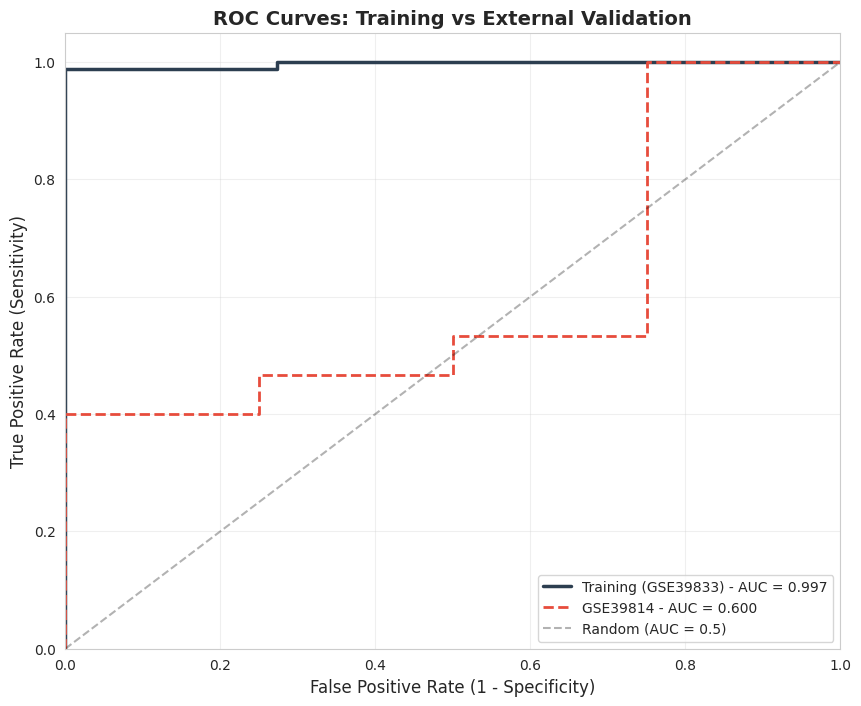

[INFO] ROC curve saved: /content/drive/MyDrive/geoexosome_results/external_validation_roc.png

STEP 6: Save External Validation Results
[INFO] Results saved: /content/drive/MyDrive/geoexosome_results/external_validation_results.json
[INFO] Predictions saved: /content/drive/MyDrive/geoexosome_results/external_predictions_GSE39814.csv
[INFO] Predictions saved: /content/drive/MyDrive/geoexosome_results/external_predictions_GSE39832.csv

✓ EXTERNAL VALIDATION COMPLETE

[SUMMARY]
  Model validated: SVM
  Training dataset: GSE39833 (n=99)
  External datasets: 2

[PATIENT DATA VALIDATION]
  Training AUC:         0.9969
  Avg Patient Ext AUC:  0.6000
  Performance drop:     0.3969

  ✗ POOR: Significant overfitting detected.
    → Model revision strongly recommended.

[CELL LINE DATA NOTE]
  GSE39832 contains HT-29 colorectal cancer cell line data.
  This is NOT suitable for patient-level clinical validation.
  Results are provided for reference only.

[NEXT STEPS]
  1. Review label assignment

In [7]:
# =============================================================================
# Cell 4: EXTERNAL VALIDATION ON INDEPENDENT DATASETS
# =============================================================================
"""
Purpose:
    Validate the trained model on completely independent cohorts to assess
    true generalization performance. This is the MOST CRITICAL step for
    publication-ready results.

Datasets:
    - GSE39814: Independent serum exosome miRNA cohort (Patient samples)
    - GSE39832: Cell line data (HT-29) - NOT suitable for patient validation

Strategy:
    1. Load external datasets from GEO
    2. Match probe IDs with training features
    3. Apply identical preprocessing (log2 transformation)
    4. Predict using the trained model (NO retraining!)
    5. Evaluate performance metrics

Version: 2.1 - Fixed variable naming conflicts
Author: Jungho Sohn
Date: 2025-12-22
"""

import os
import numpy as np
import pandas as pd
import GEOparse
import json
import warnings

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("=" * 80)
print("CELL 4: EXTERNAL VALIDATION ON INDEPENDENT DATASETS")
print("=" * 80)
print("""
[CRITICAL] This cell validates the model trained on GSE39833 using
           completely independent cohorts.

           NO learning or parameter tuning occurs on external data.
           This provides an unbiased estimate of true generalization.
""")

# =============================================================================
# STEP 0: Verify Required Variables from Previous Cells
# =============================================================================
print("\n" + "=" * 80)
print("STEP 0: Verify Required Variables")
print("=" * 80)

required_vars = {
    'best_full_model': 'Trained classifier pipeline',
    'feature_cols': 'List of selected probe IDs',
    'best_name': 'Name of best model',
    'SEED': 'Random seed for reproducibility',
    'base_save_path': 'Output directory path',
    'results': 'Nested CV results dictionary',
    'oof_predictions': 'Out-of-fold predictions dictionary'
}

missing_vars = []
for var_name, description in required_vars.items():
    if var_name not in dir():
        missing_vars.append(f"  - {var_name}: {description}")
    else:
        print(f"[OK] {var_name} found")

if missing_vars:
    raise NameError(
        f"[ERROR] Missing required variables from previous cells:\n"
        + "\n".join(missing_vars) +
        "\n\nPlease run Cell 2 (Nested CV) first!"
    )

# ┌─────────────────────────────────────────────────────────────────────────────┐
# │ CRITICAL FIX: Save Cell 2 results to avoid variable name conflicts         │
# └─────────────────────────────────────────────────────────────────────────────┘
nested_cv_results = results.copy()  # Preserve Cell 2's results dictionary

print(f"\n[INFO] Model to validate: {best_name}")
print(f"[INFO] Number of features: {len(feature_cols)}")

# Get training performance from nested CV
train_auc = nested_cv_results[best_name]['oof_auc']
train_bal_acc = nested_cv_results[best_name]['oof_balanced_accuracy']
train_sensitivity = nested_cv_results[best_name]['recall_sensitivity']
train_specificity = nested_cv_results[best_name]['specificity']

print(f"\n[INFO] Training Performance (from Nested CV):")
print(f"  - OOF AUC:          {train_auc:.4f}")
print(f"  - Balanced Accuracy: {train_bal_acc:.4f}")
print(f"  - Sensitivity:       {train_sensitivity:.4f}")
print(f"  - Specificity:       {train_specificity:.4f}")

# =============================================================================
# STEP 1: Define External Validation Datasets
# =============================================================================
print("\n" + "=" * 80)
print("STEP 1: Define External Validation Datasets")
print("=" * 80)

EXTERNAL_DATASETS = {
    'GSE39814': {
        'description': 'Serum exosome miRNA - Independent patient cohort',
        'expected_platform': 'GPL16016',
        'is_patient_data': True,  # Suitable for validation
        'notes': 'Patient serum samples'
    },
    'GSE39832': {
        'description': 'Serum exosome miRNA - Cell line data',
        'expected_platform': 'GPL16016',
        'is_patient_data': False,  # NOT suitable for patient validation
        'notes': 'HT-29 colorectal cancer cell line (NOT patient samples)'
    }
}

print("[INFO] External datasets:")
for gse_id, info in EXTERNAL_DATASETS.items():
    status = "✓ Patient data" if info['is_patient_data'] else "⚠️ Cell line (not for patient validation)"
    print(f"  - {gse_id}: {info['description']}")
    print(f"    Status: {status}")

# =============================================================================
# STEP 2: Define Helper Functions
# =============================================================================
print("\n" + "=" * 80)
print("STEP 2: Define Helper Functions")
print("=" * 80)


def bootstrap_auc_ci(y_true, y_proba, n_bootstrap=1000, alpha=0.05, random_state=42):
    """
    Compute bootstrap confidence interval for ROC-AUC.
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n = len(y_true)

    aucs = []
    for _ in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)

        # Skip if bootstrap sample doesn't contain both classes
        if len(np.unique(y_true[indices])) < 2:
            continue

        aucs.append(roc_auc_score(y_true[indices], y_proba[indices]))

    if len(aucs) == 0:
        return np.nan, np.nan

    lower = np.percentile(aucs, 100 * (alpha / 2))
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))

    return float(lower), float(upper)


def load_geo_dataset(gse_id, verbose=True):
    """
    Load GEO dataset and extract expression matrix with sample metadata.
    """
    if verbose:
        print(f"\n[INFO] Loading {gse_id} from GEO...")

    # Download and parse GEO dataset
    gse = GEOparse.get_GEO(geo=gse_id, destdir='./geo_cache', silent=True)

    if verbose:
        print(f"[INFO] Successfully loaded {gse_id}")
        print(f"  - Title: {gse.metadata.get('title', ['Unknown'])[0][:60]}...")
        print(f"  - Samples: {len(gse.gsms)}")

    # Extract sample IDs
    sample_ids = list(gse.gsms.keys())

    # Extract expression data
    expression_data = []
    sample_metadata = []

    for gsm_id in sample_ids:
        gsm = gse.gsms[gsm_id]

        # Get expression values
        if 'VALUE' in gsm.table.columns:
            values = gsm.table['VALUE'].values
        else:
            value_cols = [c for c in gsm.table.columns if 'value' in c.lower()]
            if value_cols:
                values = gsm.table[value_cols[0]].values
            else:
                raise KeyError(f"No expression value column found in {gsm_id}")

        expression_data.append(values)

        # Extract metadata for label assignment
        characteristics = gsm.metadata.get('characteristics_ch1', [])
        title = gsm.metadata.get('title', [''])[0]
        source = gsm.metadata.get('source_name_ch1', [''])[0]

        sample_metadata.append({
            'sample_id': gsm_id,
            'title': title,
            'source': source,
            'characteristics': '; '.join(characteristics) if characteristics else ''
        })

    # Get probe IDs from first sample
    probe_ids = gse.gsms[sample_ids[0]].table['ID_REF'].tolist()

    # Create expression DataFrame
    expr_df = pd.DataFrame(
        expression_data,
        index=sample_ids,
        columns=probe_ids
    )

    # Create metadata DataFrame
    sample_info = pd.DataFrame(sample_metadata)
    sample_info.set_index('sample_id', inplace=True)

    if verbose:
        print(f"  - Expression matrix shape: {expr_df.shape}")
        print(f"  - Probe count: {len(probe_ids)}")

    return expr_df, sample_info, gse


def assign_labels_external(sample_info, gse_id, verbose=True):
    """
    Assign binary labels (0=healthy, 1=cancer) based on sample metadata.
    """
    labels = []
    label_log = []

    # Define keywords for classification
    healthy_keywords = [
        'healthy', 'normal', 'control', 'hc', 'nc',
        'non-cancer', 'non-tumor', 'benign', 'volunteer'
    ]
    cancer_keywords = [
        'cancer', 'tumor', 'crc', 'colorectal', 'carcinoma',
        'malignant', 'adenocarcinoma', 'patient', 'case'
    ]

    # Cell line keywords (for GSE39832)
    cell_line_keywords = ['ht-29', 'ht29', 'caco', 'sw480', 'hct', 'cell line']

    for sample_id in sample_info.index:
        row = sample_info.loc[sample_id]

        # Combine all text fields for keyword search
        text_to_search = ' '.join([
            str(row.get('title', '')),
            str(row.get('source', '')),
            str(row.get('characteristics', ''))
        ]).lower()

        # Check if this is cell line data
        is_cell_line = any(kw in text_to_search for kw in cell_line_keywords)

        # Check for healthy/cancer indicators
        is_healthy = any(kw in text_to_search for kw in healthy_keywords)
        is_cancer = any(kw in text_to_search for kw in cancer_keywords)

        # Assign label with priority logic
        if is_cell_line:
            label = 1  # Cell lines are cancer-derived
            reason = "Cell line sample (cancer-derived)"
        elif is_healthy and not is_cancer:
            label = 0
            reason = "Matched healthy keywords"
        elif is_cancer and not is_healthy:
            label = 1
            reason = "Matched cancer keywords"
        elif is_healthy and is_cancer:
            if 'healthy' in text_to_search or 'normal control' in text_to_search:
                label = 0
                reason = "Matched 'healthy' specifically (ambiguous case)"
            else:
                label = 1
                reason = "Matched cancer keywords (ambiguous case)"
        else:
            label = 1  # Default to cancer if unclear
            reason = "No clear keywords - defaulting to cancer"

        labels.append(label)
        label_log.append({
            'sample_id': sample_id,
            'title': row.get('title', ''),
            'source': row.get('source', ''),
            'label': label,
            'reason': reason,
            'is_cell_line': is_cell_line
        })

    labels = np.array(labels)

    if verbose:
        n_healthy = (labels == 0).sum()
        n_cancer = (labels == 1).sum()
        n_cell_line = sum(1 for log in label_log if log.get('is_cell_line', False))

        print(f"\n[INFO] Label assignment for {gse_id}:")
        print(f"  - Healthy controls: {n_healthy}")
        print(f"  - Cancer patients: {n_cancer}")

        if n_cell_line > 0:
            print(f"  ⚠️  WARNING: {n_cell_line} samples are cell line data!")
            print(f"     Cell line data is NOT suitable for patient-level validation.")

        if n_healthy == 0 or n_cancer == 0:
            print(f"  ⚠️  WARNING: Only one class detected!")
            print(f"  Sample titles for review:")
            for log_entry in label_log[:5]:
                print(f"    - {log_entry['title'][:50]}... → Label: {log_entry['label']}")

    return labels, label_log


def validate_on_external_dataset(
    model,
    feature_list,
    external_expr,
    external_labels,
    dataset_name,
    seed=42,
    verbose=True
):
    """
    Validate trained model on external dataset.

    Returns validation_result dict (renamed from 'results' to avoid conflicts)
    """
    if verbose:
        print(f"\n{'─' * 60}")
        print(f"Validating on {dataset_name}")
        print(f"{'─' * 60}")

    # Step 1: Match features (probe IDs)
    available_features = set(external_expr.columns)
    required_features = set(feature_list)

    matched_features = list(required_features & available_features)
    missing_features = list(required_features - available_features)

    match_rate = len(matched_features) / len(required_features) * 100

    if verbose:
        print(f"[INFO] Feature matching:")
        print(f"  - Required features: {len(required_features)}")
        print(f"  - Matched features: {len(matched_features)} ({match_rate:.1f}%)")
        print(f"  - Missing features: {len(missing_features)}")

    if match_rate < 50:
        print(f"[ERROR] Less than 50% feature match. Validation may be unreliable.")

    # Step 2: Prepare feature matrix in SAME ORDER as training
    X_external = np.zeros((len(external_expr), len(feature_list)))

    for i, feat in enumerate(feature_list):
        if feat in external_expr.columns:
            X_external[:, i] = external_expr[feat].values
        else:
            X_external[:, i] = 0.0

    # Step 3: Apply log2 transformation if needed
    if external_expr.values.max() > 20:
        if verbose:
            print(f"[INFO] Applying log2(x + 1) transformation")
        X_external = np.log2(X_external + 1.0)
    else:
        if verbose:
            print(f"[INFO] Data appears log2-transformed. Using as-is.")

    # Handle any infinite or NaN values
    X_external = np.nan_to_num(X_external, nan=0.0, posinf=0.0, neginf=0.0)

    # Step 4: Predict using trained model
    try:
        y_proba = model.predict_proba(X_external)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
    except Exception as e:
        print(f"[ERROR] Prediction failed: {str(e)}")
        return None

    # Step 5: Calculate performance metrics
    unique_labels = np.unique(external_labels)
    if len(unique_labels) < 2:
        print(f"[WARNING] Only one class present. AUC cannot be computed.")
        auc = np.nan
        ci_lower, ci_upper = np.nan, np.nan
    else:
        auc = roc_auc_score(external_labels, y_proba)
        ci_lower, ci_upper = bootstrap_auc_ci(
            external_labels, y_proba, n_bootstrap=1000, random_state=seed
        )

    acc = accuracy_score(external_labels, y_pred)
    bal_acc = balanced_accuracy_score(external_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        external_labels, y_pred, average='binary', zero_division=0
    )

    cm = confusion_matrix(external_labels, y_pred)

    # Calculate specificity and sensitivity
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    else:
        specificity = np.nan
        sensitivity = recall

    # Compile results
    validation_result = {
        'dataset': dataset_name,
        'n_samples': len(external_labels),
        'n_healthy': int((external_labels == 0).sum()),
        'n_cancer': int((external_labels == 1).sum()),
        'feature_match_rate': float(match_rate),
        'n_matched_features': len(matched_features),
        'n_missing_features': len(missing_features),
        'auc': float(auc) if not np.isnan(auc) else None,
        'auc_ci_lower': float(ci_lower) if not np.isnan(ci_lower) else None,
        'auc_ci_upper': float(ci_upper) if not np.isnan(ci_upper) else None,
        'accuracy': float(acc),
        'balanced_accuracy': float(bal_acc),
        'sensitivity': float(sensitivity) if not np.isnan(sensitivity) else None,
        'specificity': float(specificity) if not np.isnan(specificity) else None,
        'precision': float(precision),
        'f1_score': float(f1),
        'confusion_matrix': cm.tolist(),
        'y_true': external_labels.tolist(),
        'y_proba': y_proba.tolist(),
        'y_pred': y_pred.tolist()
    }

    # Print results
    if verbose:
        print(f"\n[RESULTS] {dataset_name}")
        print(f"  Samples: {validation_result['n_samples']} "
              f"({validation_result['n_healthy']} HC, {validation_result['n_cancer']} CRC)")
        print(f"  Feature match: {validation_result['feature_match_rate']:.1f}%")
        print(f"  ────────────────────────────────────")
        if validation_result['auc'] is not None:
            print(f"  AUC:              {validation_result['auc']:.4f} "
                  f"(95% CI: [{validation_result['auc_ci_lower']:.4f}, "
                  f"{validation_result['auc_ci_upper']:.4f}])")
        else:
            print(f"  AUC:              N/A (single class)")
        print(f"  Accuracy:         {validation_result['accuracy']:.4f}")
        print(f"  Balanced Acc:     {validation_result['balanced_accuracy']:.4f}")
        if validation_result['sensitivity'] is not None:
            print(f"  Sensitivity:      {validation_result['sensitivity']:.4f}")
        if validation_result['specificity'] is not None:
            print(f"  Specificity:      {validation_result['specificity']:.4f}")
        print(f"  F1-score:         {validation_result['f1_score']:.4f}")
        print(f"  Confusion Matrix:")
        print(f"    {cm}")

    return validation_result


# =============================================================================
# STEP 3: Load and Validate External Datasets
# =============================================================================
print("\n" + "=" * 80)
print("STEP 3: Load and Validate External Datasets")
print("=" * 80)

# Create cache directory for GEO downloads
os.makedirs('./geo_cache', exist_ok=True)

external_results = {}
all_label_logs = {}

for gse_id, info in EXTERNAL_DATASETS.items():
    print(f"\n{'═' * 80}")
    print(f"Processing {gse_id}: {info['description']}")
    if not info['is_patient_data']:
        print(f"⚠️  NOTE: This is cell line data - results for reference only")
    print(f"{'═' * 80}")

    try:
        # Load dataset
        expr_df, sample_info, gse = load_geo_dataset(gse_id, verbose=True)

        # Assign labels
        labels, label_log = assign_labels_external(sample_info, gse_id, verbose=True)
        all_label_logs[gse_id] = label_log

        # Save label log for transparency
        label_log_df = pd.DataFrame(label_log)
        label_log_path = os.path.join(base_save_path, f"external_label_log_{gse_id}.csv")
        label_log_df.to_csv(label_log_path, index=False)
        print(f"[INFO] Label log saved: {label_log_path}")

        # ┌─────────────────────────────────────────────────────────────────────┐
        # │ FIX: Use different variable name to avoid overwriting Cell 2 results│
        # └─────────────────────────────────────────────────────────────────────┘
        validation_result = validate_on_external_dataset(
            model=best_full_model,
            feature_list=feature_cols,
            external_expr=expr_df,
            external_labels=labels,
            dataset_name=gse_id,
            seed=SEED,
            verbose=True
        )

        if validation_result is not None:
            validation_result['is_patient_data'] = info['is_patient_data']
            external_results[gse_id] = validation_result

    except Exception as e:
        print(f"[ERROR] Failed to process {gse_id}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue


# =============================================================================
# STEP 4: Summary and Comparison
# =============================================================================
print("\n" + "=" * 80)
print("STEP 4: External Validation Summary")
print("=" * 80)

if len(external_results) == 0:
    print("[ERROR] No external datasets were successfully validated.")
else:
    # Create summary table
    print("\n┌" + "─" * 78 + "┐")
    print("│" + " EXTERNAL VALIDATION RESULTS ".center(78) + "│")
    print("├" + "─" * 78 + "┤")
    print(f"│ {'Dataset':<12} │ {'Type':<8} │ {'N':<5} │ {'AUC':<8} │ {'95% CI':<15} │ {'Bal.Acc':<7} │ {'Sens':<5} │ {'Spec':<5} │")
    print("├" + "─" * 78 + "┤")

    for gse_id, res in external_results.items():
        auc_str = f"{res['auc']:.4f}" if res['auc'] else "N/A"
        ci_str = f"[{res['auc_ci_lower']:.3f},{res['auc_ci_upper']:.3f}]" if res['auc_ci_lower'] else "N/A"
        sens_str = f"{res['sensitivity']:.2f}" if res['sensitivity'] else "N/A"
        spec_str = f"{res['specificity']:.2f}" if res['specificity'] else "N/A"
        data_type = "Patient" if res.get('is_patient_data', True) else "Cell"

        print(f"│ {gse_id:<12} │ {data_type:<8} │ {res['n_samples']:<5} │ {auc_str:<8} │ {ci_str:<15} │ {res['balanced_accuracy']:.4f}  │ {sens_str:<5} │ {spec_str:<5} │")

    print("└" + "─" * 78 + "┘")

    # Compare with training performance
    print("\n" + "─" * 80)
    print("COMPARISON: Training vs External Validation")
    print("─" * 80)

    # Use preserved nested CV results
    print(f"\n{'Metric':<20} │ {'Training (CV)':<15} │ ", end="")
    for gse_id in external_results.keys():
        print(f"{gse_id:<15} │ ", end="")
    print()
    print("─" * (22 + 18 + 18 * len(external_results)))

    print(f"{'AUC':<20} │ {train_auc:.4f}          │ ", end="")
    for gse_id, res in external_results.items():
        auc_str = f"{res['auc']:.4f}" if res['auc'] else "N/A"
        print(f"{auc_str:<15} │ ", end="")
    print()

    print(f"{'Balanced Accuracy':<20} │ {train_bal_acc:.4f}          │ ", end="")
    for gse_id, res in external_results.items():
        print(f"{res['balanced_accuracy']:.4f}          │ ", end="")
    print()

    # Performance drop analysis (only for patient data)
    print("\n" + "─" * 80)
    print("PERFORMANCE DROP ANALYSIS (Patient Data Only)")
    print("─" * 80)

    patient_datasets = {k: v for k, v in external_results.items()
                        if v.get('is_patient_data', True)}

    for gse_id, res in patient_datasets.items():
        if res['auc'] is not None:
            auc_drop = train_auc - res['auc']
            bal_acc_drop = train_bal_acc - res['balanced_accuracy']

            print(f"\n{gse_id}:")
            print(f"  AUC drop:          {auc_drop:+.4f} ({train_auc:.4f} → {res['auc']:.4f})")
            print(f"  Balanced Acc drop: {bal_acc_drop:+.4f} ({train_bal_acc:.4f} → {res['balanced_accuracy']:.4f})")

            # Interpretation
            if auc_drop < 0.05:
                print(f"  ✓ Excellent generalization (AUC drop < 5%)")
            elif auc_drop < 0.10:
                print(f"  ○ Good generalization (AUC drop < 10%)")
            elif auc_drop < 0.20:
                print(f"  △ Moderate generalization (AUC drop < 20%)")
            else:
                print(f"  ✗ Poor generalization (AUC drop ≥ 20%) - Overfitting likely")


# =============================================================================
# STEP 5: Generate Visualization
# =============================================================================
print("\n" + "=" * 80)
print("STEP 5: Generate ROC Curves for External Validation")
print("=" * 80)

if len(external_results) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot training ROC (from OOF predictions)
    train_y_true = oof_predictions[best_name]['y_true']
    train_y_proba = oof_predictions[best_name]['y_proba']
    fpr_train, tpr_train, _ = roc_curve(train_y_true, train_y_proba)

    ax.plot(
        fpr_train, tpr_train,
        linewidth=2.5,
        label=f'Training (GSE39833) - AUC = {train_auc:.3f}',
        color='#2C3E50'
    )

    # Plot external validation ROCs
    colors = {'GSE39814': '#E74C3C', 'GSE39832': '#95A5A6'}  # Gray for cell line
    linestyles = {'GSE39814': '--', 'GSE39832': ':'}

    for gse_id, res in external_results.items():
        if res['auc'] is not None:
            y_true = np.array(res['y_true'])
            y_proba = np.array(res['y_proba'])
            fpr, tpr, _ = roc_curve(y_true, y_proba)

            label_suffix = "" if res.get('is_patient_data', True) else " (Cell line)"

            ax.plot(
                fpr, tpr,
                linewidth=2,
                linestyle=linestyles.get(gse_id, '--'),
                label=f'{gse_id}{label_suffix} - AUC = {res["auc"]:.3f}',
                color=colors.get(gse_id, '#3498DB')
            )

    # Diagonal reference line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random (AUC = 0.5)')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    ax.set_title('ROC Curves: Training vs External Validation', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Save figure
    roc_path = os.path.join(base_save_path, 'external_validation_roc.png')
    plt.savefig(roc_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"[INFO] ROC curve saved: {roc_path}")


# =============================================================================
# STEP 6: Save Comprehensive Results
# =============================================================================
print("\n" + "=" * 80)
print("STEP 6: Save External Validation Results")
print("=" * 80)

# Prepare JSON-serializable results
json_output = {
    'training_dataset': 'GSE39833',
    'model_name': best_name,
    'n_features': len(feature_cols),
    'training_performance': {
        'oof_auc': float(train_auc),
        'oof_balanced_accuracy': float(train_bal_acc),
        'oof_sensitivity': float(train_sensitivity),
        'oof_specificity': float(train_specificity)
    },
    'external_validation': {}
}

for gse_id, res in external_results.items():
    # Remove large arrays from JSON
    json_res = {k: v for k, v in res.items() if k not in ['y_true', 'y_proba', 'y_pred']}
    json_output['external_validation'][gse_id] = json_res

# Save JSON
json_path = os.path.join(base_save_path, 'external_validation_results.json')
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(json_output, f, indent=2, ensure_ascii=False)
print(f"[INFO] Results saved: {json_path}")

# Save detailed CSV for each external dataset
for gse_id, res in external_results.items():
    detail_df = pd.DataFrame({
        'y_true': res['y_true'],
        'y_proba': res['y_proba'],
        'y_pred': res['y_pred']
    })
    detail_path = os.path.join(base_save_path, f'external_predictions_{gse_id}.csv')
    detail_df.to_csv(detail_path, index=False)
    print(f"[INFO] Predictions saved: {detail_path}")


# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("✓ EXTERNAL VALIDATION COMPLETE")
print("=" * 80)

print(f"""
[SUMMARY]
  Model validated: {best_name}
  Training dataset: GSE39833 (n=99)
  External datasets: {len(external_results)}
""")

# Final interpretation (patient data only)
patient_results = {k: v for k, v in external_results.items()
                   if v.get('is_patient_data', True) and v['auc'] is not None}

if len(patient_results) > 0:
    avg_patient_auc = np.mean([res['auc'] for res in patient_results.values()])

    print(f"[PATIENT DATA VALIDATION]")
    print(f"  Training AUC:         {train_auc:.4f}")
    print(f"  Avg Patient Ext AUC:  {avg_patient_auc:.4f}")
    print(f"  Performance drop:     {train_auc - avg_patient_auc:.4f}")

    if avg_patient_auc >= 0.85:
        print(f"\n  ✓ EXCELLENT: Model shows strong generalization.")
        print(f"    → Ready for publication with strong external validation.")
    elif avg_patient_auc >= 0.75:
        print(f"\n  ○ GOOD: Model generalizes reasonably well.")
        print(f"    → Publishable with appropriate limitations discussed.")
    elif avg_patient_auc >= 0.65:
        print(f"\n  △ MODERATE: Some overfitting observed.")
        print(f"    → Consider feature reduction or regularization.")
    else:
        print(f"\n  ✗ POOR: Significant overfitting detected.")
        print(f"    → Model revision strongly recommended.")

# Note about cell line data
cell_line_results = {k: v for k, v in external_results.items()
                     if not v.get('is_patient_data', True)}
if len(cell_line_results) > 0:
    print(f"\n[CELL LINE DATA NOTE]")
    print(f"  GSE39832 contains HT-29 colorectal cancer cell line data.")
    print(f"  This is NOT suitable for patient-level clinical validation.")
    print(f"  Results are provided for reference only.")

print(f"""
[NEXT STEPS]
  1. Review label assignment logs for accuracy
  2. If performance drop > 0.15, consider:
     - Reducing feature count (use CV-stable features only)
     - Increasing regularization
     - Using simpler model
  3. Update manuscript with external validation results

[FILES GENERATED]
  - external_validation_results.json
  - external_validation_roc.png
  - external_label_log_GSE39814.csv
  - external_label_log_GSE39832.csv
  - external_predictions_GSE39814.csv
  - external_predictions_GSE39832.csv
""")

print("=" * 80)